In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import pandas as pd
import numpy as np

from Data.ReadDatasets import ReadDataset_train_Sanger, ReadDataset_test_Sanger, Parser
from VAE.VAE_pytorch import VAE_Sanger, loss_function, loss_function2, train, test, train_warmup, test_warmup
from Plotting.plot_latent_encoding import plot_latent_encoding, plot_GE_latent_encoding

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, SpectralEmbedding

Using TensorFlow backend.


In [2]:
#hyperparameters
kwargs, device, args=Parser(argparse)
args.epochs=100
args.learning_rate=0.0001
args.encoding_dim=50
#args.batch_size=128
args.batch_size=100
args.hidden_layers=[512,128]

In [3]:
########### READ DATA ###########
dataset_test = ReadDataset_test_Sanger()
dataset_train = ReadDataset_train_Sanger()
train_loader = DataLoader(dataset=dataset_train,shuffle=True,
                         batch_size=args.batch_size, **kwargs)
test_loader = DataLoader(dataset=dataset_test,shuffle=True,
                         batch_size=args.batch_size, **kwargs)


In [4]:
########### IMPORT MODEL AND OPTIMIZER ###########
model = VAE_Sanger().to(device) # create VAE model 
optimizer = optim.Adam(model.parameters(), lr=1e-3) # import optimizer
print(model)

VAE_Sanger(
  (input_linear): Linear(in_features=1845, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_middle): Linear(in_features=512, out_features=128, bias=True)
  (enc_1): Linear(in_features=128, out_features=50, bias=True)
  (enc_2): Linear(in_features=128, out_features=50, bias=True)
  (dec_0): Linear(in_features=50, out_features=128, bias=True)
  (dec_middle): Linear(in_features=128, out_features=512, bias=True)
  (output_linear): Linear(in_features=512, out_features=1845, bias=True)
)


In [5]:
########### TRAIN THE NETWORK ###########
if __name__ == "__main__":
    for epoch in range(1, int(3*args.epochs/5) + 1): # warmup (without disentanglement term)
        train_warmup(model, epoch, train_loader, optimizer) # 
        test_warmup(model, epoch, test_loader, optimizer)
        with torch.no_grad():
            sample = torch.randn(64, 50).to(device)
            sample = model.decode(sample).cpu()

    for epoch in range(int(3*args.epochs/5) + 1, args.epochs + 1 ): # full loss function
        train(model, epoch, train_loader, optimizer) # 
        test(model, epoch, test_loader, optimizer)
        with torch.no_grad():
            sample = torch.randn(64, 50).to(device)
            sample = model.decode(sample).cpu()            

Train Epoch: 1 [0/1422 (0%)]	Loss: 1281.393125
Train Epoch: 1 [1000/1422 (67%)]	Loss: 209.456133
====> Epoch: 1 Average loss: 680.8191
====> Test set loss: 132.9314
Train Epoch: 2 [0/1422 (0%)]	Loss: 169.383906
Train Epoch: 2 [1000/1422 (67%)]	Loss: 129.193984
====> Epoch: 2 Average loss: 158.7162
====> Test set loss: 117.5209
Train Epoch: 3 [0/1422 (0%)]	Loss: 98.517871
Train Epoch: 3 [1000/1422 (67%)]	Loss: 91.346709
====> Epoch: 3 Average loss: 96.8858
====> Test set loss: 97.6140
Train Epoch: 4 [0/1422 (0%)]	Loss: 80.582002
Train Epoch: 4 [1000/1422 (67%)]	Loss: 88.681455
====> Epoch: 4 Average loss: 88.2673
====> Test set loss: 90.5423
Train Epoch: 5 [0/1422 (0%)]	Loss: 88.654590
Train Epoch: 5 [1000/1422 (67%)]	Loss: 86.865088
====> Epoch: 5 Average loss: 86.8775
====> Test set loss: 90.0713
Train Epoch: 6 [0/1422 (0%)]	Loss: 87.488174
Train Epoch: 6 [1000/1422 (67%)]	Loss: 87.502148
====> Epoch: 6 Average loss: 86.4015
====> Test set loss: 89.4161
Train Epoch: 7 [0/1422 (0%)]	Lo

====> Test set loss: 73.4451
Train Epoch: 52 [0/1422 (0%)]	Loss: 72.561445
Train Epoch: 52 [1000/1422 (67%)]	Loss: 68.559219
====> Epoch: 52 Average loss: 71.3845
====> Test set loss: 72.9007
Train Epoch: 53 [0/1422 (0%)]	Loss: 71.973428
Train Epoch: 53 [1000/1422 (67%)]	Loss: 68.423657
====> Epoch: 53 Average loss: 71.1517
====> Test set loss: 72.8130
Train Epoch: 54 [0/1422 (0%)]	Loss: 71.880073
Train Epoch: 54 [1000/1422 (67%)]	Loss: 70.562397
====> Epoch: 54 Average loss: 71.0113
====> Test set loss: 72.7390
Train Epoch: 55 [0/1422 (0%)]	Loss: 75.284961
Train Epoch: 55 [1000/1422 (67%)]	Loss: 69.602588
====> Epoch: 55 Average loss: 70.9172
====> Test set loss: 72.4047
Train Epoch: 56 [0/1422 (0%)]	Loss: 74.283584
Train Epoch: 56 [1000/1422 (67%)]	Loss: 71.620801
====> Epoch: 56 Average loss: 70.8136
====> Test set loss: 72.8612
Train Epoch: 57 [0/1422 (0%)]	Loss: 67.720605
Train Epoch: 57 [1000/1422 (67%)]	Loss: 71.936411
====> Epoch: 57 Average loss: 71.0019
====> Test set loss: 7

In [6]:
## Find the latent representation/encode the data
sample = dataset_train.x_data.to(device)
sample_enc_b = model.encode(sample.view(-1, 1845))[0].cpu()
print(sample_enc_b.shape)

# find the decoded representation of the data
sample_dec_b= model.decode(sample_enc_b.cuda().view(-1, 50)).cpu()
sample_dec=sample_dec_b.detach().numpy()
print(sample_dec)
print(sample)



sample_enc=sample_enc_b.detach().numpy()
print(sample_enc.shape)

torch.Size([1422, 50])
[[ 0.01966843  0.00472066  0.06108396 ...,  0.00500379  0.02573737
   0.00974282]
 [ 0.01016556  0.00581462  0.0152018  ...,  0.01053777  0.01497363
   0.00121109]
 [ 0.00222319  0.01175269  0.03089434 ...,  0.08248591  0.00415722
   0.0008662 ]
 ..., 
 [ 0.00467901  0.02338202  0.07421436 ...,  0.11767762  0.01128932
   0.00348384]
 [ 0.00333534  0.02072227  0.06715781 ...,  0.12215667  0.00959198
   0.00214077]
 [ 0.00379781  0.01618136  0.10195095 ...,  0.09067361  0.01635639
   0.00260145]]
tensor([[0.0005, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0011, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0085,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0134, 0.0075, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0002, 0.0000, 0.0004,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
(1422, 50)


In [7]:
# tSNE transform to plot in 2D
sample_enc_tsne=TSNE(n_components=2).fit_transform(sample_enc)

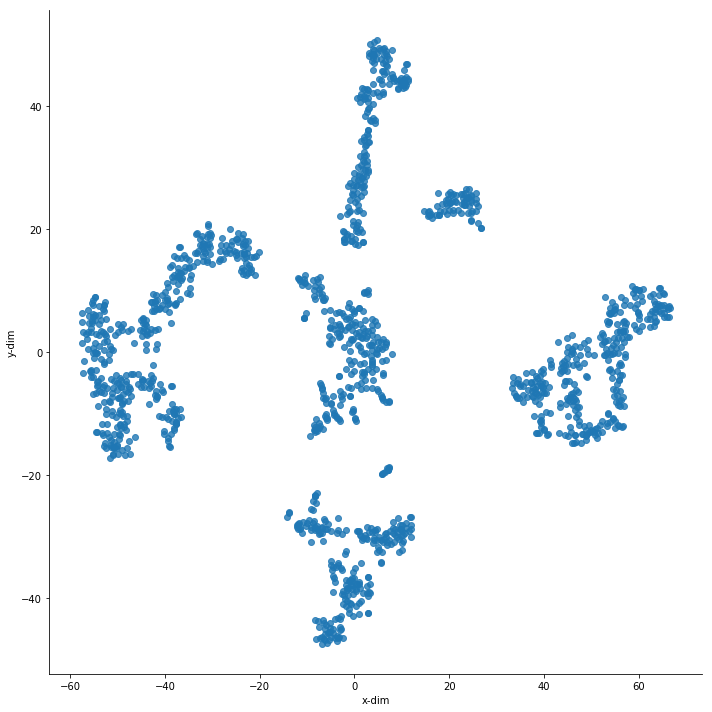

In [8]:
# plot tSNE representation of the encoding
vae_df = pd.DataFrame( data={'x-dim': sample_enc_tsne[:, 0], 'y-dim': sample_enc_tsne[:, 1], 'Model': 'VAE'})

sns_plot = sns.lmplot(data=vae_df, x='x-dim', y='y-dim', palette='Reds',
                          fit_reg=False, size=10, legend=False)
plt.show()

# InfoVAE

In [10]:
from VAE.INFO_VAE_pytorch import train_mmd, test_mmd, train_mmd_warmup, test_mmd_warmup

In [11]:
model_dis = VAE_Sanger().to(device) # create VAE model 
optimizer = optim.Adam(model_dis.parameters(), lr=1e-3) # import optimizer
print(model)

VAE_Sanger(
  (input_linear): Linear(in_features=1845, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_middle): Linear(in_features=512, out_features=128, bias=True)
  (enc_1): Linear(in_features=128, out_features=50, bias=True)
  (enc_2): Linear(in_features=128, out_features=50, bias=True)
  (dec_0): Linear(in_features=50, out_features=128, bias=True)
  (dec_middle): Linear(in_features=128, out_features=512, bias=True)
  (output_linear): Linear(in_features=512, out_features=1845, bias=True)
)


In [12]:
if __name__ == "__main__":
    for epoch in range(1, int(args.epochs) + 1 ): # 
        train_mmd(model_dis, epoch, train_loader, optimizer, latent_dim=50) # 
        test_mmd(model_dis, epoch, test_loader, optimizer, latent_dim=50)
        with torch.no_grad():
            sample = torch.randn(64, 50).to(device)
            sample = model.decode(sample).cpu()         

Train Epoch: 1 [0/1422 (0%)]	Loss: 1281.394063
Train Epoch: 1 [1000/1422 (67%)]	Loss: 209.536992
====> Epoch: 1 Average loss: 680.8449
====> Test set loss: 6.3545
Train Epoch: 2 [0/1422 (0%)]	Loss: 164.196777
Train Epoch: 2 [1000/1422 (67%)]	Loss: 119.867178
====> Epoch: 2 Average loss: 159.1344
====> Test set loss: 5.8534
Train Epoch: 3 [0/1422 (0%)]	Loss: 94.940547
Train Epoch: 3 [1000/1422 (67%)]	Loss: 91.241504
====> Epoch: 3 Average loss: 97.1292
====> Test set loss: 5.0274
Train Epoch: 4 [0/1422 (0%)]	Loss: 93.936074
Train Epoch: 4 [1000/1422 (67%)]	Loss: 84.272275
====> Epoch: 4 Average loss: 88.3305
====> Test set loss: 4.5107
Train Epoch: 5 [0/1422 (0%)]	Loss: 86.822070
Train Epoch: 5 [1000/1422 (67%)]	Loss: 91.371846
====> Epoch: 5 Average loss: 87.1239
====> Test set loss: 4.2244
Train Epoch: 6 [0/1422 (0%)]	Loss: 88.423330
Train Epoch: 6 [1000/1422 (67%)]	Loss: 83.548447
====> Epoch: 6 Average loss: 86.3319
====> Test set loss: 4.7026
Train Epoch: 7 [0/1422 (0%)]	Loss: 82.9

====> Test set loss: 3.6505
Train Epoch: 52 [0/1422 (0%)]	Loss: 69.334390
Train Epoch: 52 [1000/1422 (67%)]	Loss: 70.366694
====> Epoch: 52 Average loss: 71.9695
====> Test set loss: 3.2561
Train Epoch: 53 [0/1422 (0%)]	Loss: 68.530527
Train Epoch: 53 [1000/1422 (67%)]	Loss: 68.177407
====> Epoch: 53 Average loss: 71.9695
====> Test set loss: 3.7478
Train Epoch: 54 [0/1422 (0%)]	Loss: 71.592412
Train Epoch: 54 [1000/1422 (67%)]	Loss: 70.044795
====> Epoch: 54 Average loss: 71.6280
====> Test set loss: 3.4757
Train Epoch: 55 [0/1422 (0%)]	Loss: 73.669390
Train Epoch: 55 [1000/1422 (67%)]	Loss: 75.909375
====> Epoch: 55 Average loss: 71.5911
====> Test set loss: 3.7163
Train Epoch: 56 [0/1422 (0%)]	Loss: 67.968994
Train Epoch: 56 [1000/1422 (67%)]	Loss: 75.403403
====> Epoch: 56 Average loss: 71.5127
====> Test set loss: 3.6923
Train Epoch: 57 [0/1422 (0%)]	Loss: 70.672983
Train Epoch: 57 [1000/1422 (67%)]	Loss: 74.399946
====> Epoch: 57 Average loss: 71.4071
====> Test set loss: 3.7596


In [13]:
## Find the latent representation/encode the data
sample_enc_b_dis = model.encode(dataset_train.x_data.to(device).view(-1, 1845))[0].cpu()

sample_enc_dis=sample_enc_b_dis.detach().numpy()
print(sample_enc_dis[:,0].shape)

(1422,)


In [14]:
sample_enc_tsne_dis=TSNE(n_components=2).fit_transform(sample_enc_dis)

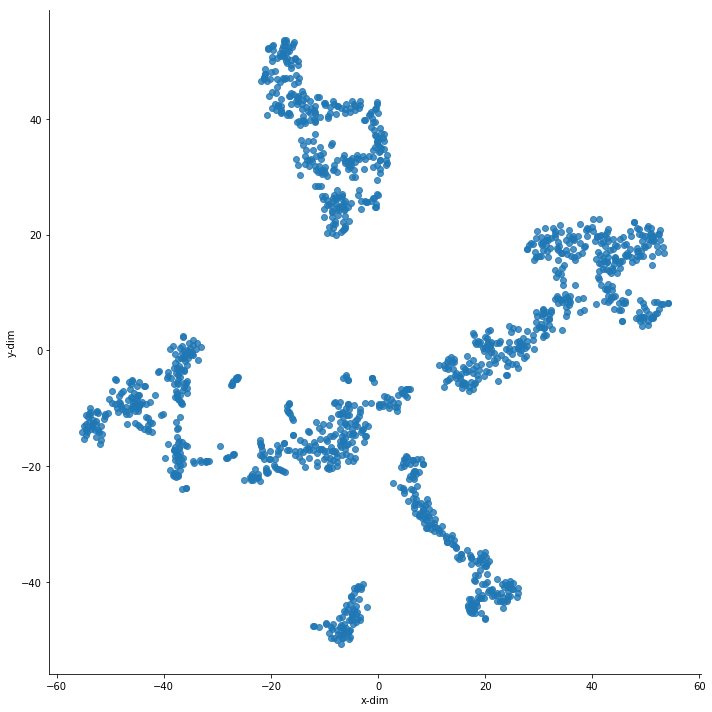

In [15]:
vae_df_dis = pd.DataFrame( data={'x-dim': sample_enc_tsne_dis[:, 0], 'y-dim': sample_enc_tsne_dis[:, 1], 'Model': 'VAE'})

sns_plot = sns.lmplot(data=vae_df_dis, x='x-dim', y='y-dim', palette='Reds',
                          fit_reg=False, size=10, legend=False)
plt.show()

# CLUSTERING


In [16]:
from Clustering.clustering import compute_clustering_gaussian, compute_clustering_kmeans

In [17]:
# compute/find clusters using mixed gaussian and k-means, over the encoded components and over the tSNE transformation
clusters_gaussian_TSNE_dis=compute_clustering_gaussian(sample_enc_tsne_dis, num_clusters=5, embedding_type='TSNE')
clusters_gaussian_dis=compute_clustering_gaussian(sample_enc_dis, num_clusters=5, embedding_type='')
clusters_gaussian_TSNE=compute_clustering_gaussian(sample_enc_tsne, num_clusters=5, embedding_type='TSNE')
clusters_gaussian=compute_clustering_gaussian(sample_enc, num_clusters=5, embedding_type='')

clusters_kmeans_TSNE_dis=compute_clustering_kmeans(sample_enc_tsne_dis, num_clusters=5, embedding_type='TSNE')
clusters_kmeans_dis=compute_clustering_kmeans(sample_enc_dis, num_clusters=5, embedding_type='')
clusters_kmeans_TSNE=compute_clustering_kmeans(sample_enc_tsne, num_clusters=5, embedding_type='TSNE')
clusters_kmeans=compute_clustering_kmeans(sample_enc, num_clusters=5, embedding_type='')

In [18]:
### create maps to assign a label to each cell according to the clusters
#print(clusters_gaussian_TSNE.shape)
labels=clusters_gaussian_TSNE_dis
label_map=[labels[i] for i in np.arange(labels.shape[0])]
label_maps=['clusters' for i in np.arange(labels.shape[0])]
Label_Maps={label_maps[i]:label_map[i] for i in np.arange(labels.shape[0])}
print(list(Label_Maps.values()))
print(labels.shape[0])

[3]
1422


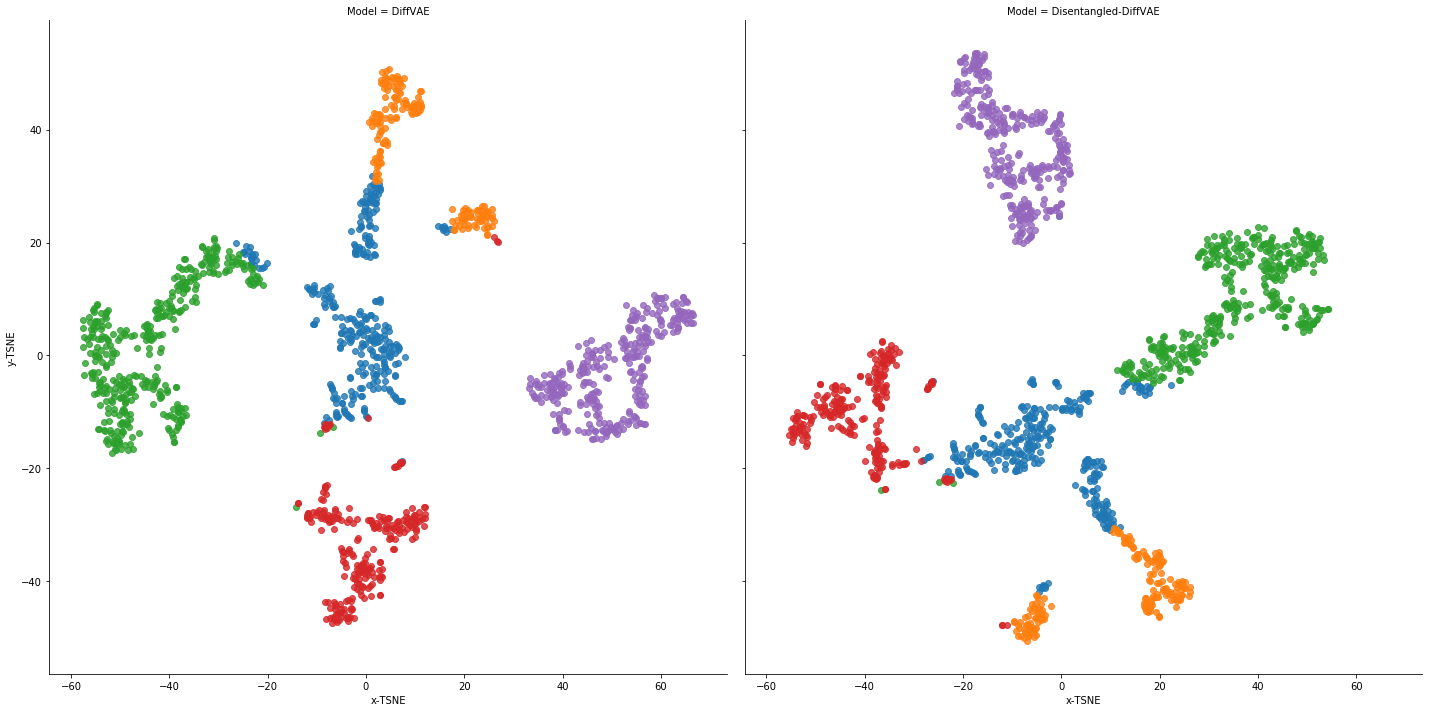

In [19]:
plot_latent_encoding(clusters_kmeans_dis, sample_enc_tsne, sample_enc_tsne_dis, n_components=50)

## Map clusters to encoded components

In [20]:
from Clustering.clusters_to_encoded_components import compute_diff_capacity_latent_dim

In [21]:
# save clusters as labels so we can continue and map them to the latent components
labels_clusters = np.array([clusters_gaussian_dis, clusters_gaussian, clusters_kmeans_dis, clusters_kmeans])


50
     Latent dimension Cell type  Percentage
0                   0         1       26.19
1                   1         1        2.17
2                   2         1       45.71
3                   3         1       18.18
4                   4         1        9.62
5                   5         1        1.22
6                   6         1        9.52
7                   7         1       28.26
8                   8         1        5.66
9                   9         1       10.91
10                 10         1       22.22
11                 11         1       26.32
12                 12         1        2.63
13                 13         1       25.76
14                 14         1       17.14
15                 15         1        6.25
16                 16         1        2.17
17                 17         1        1.55
18                 18         1        0.00
19                 19         1       44.44
20                 20         1        0.00
21                 21        

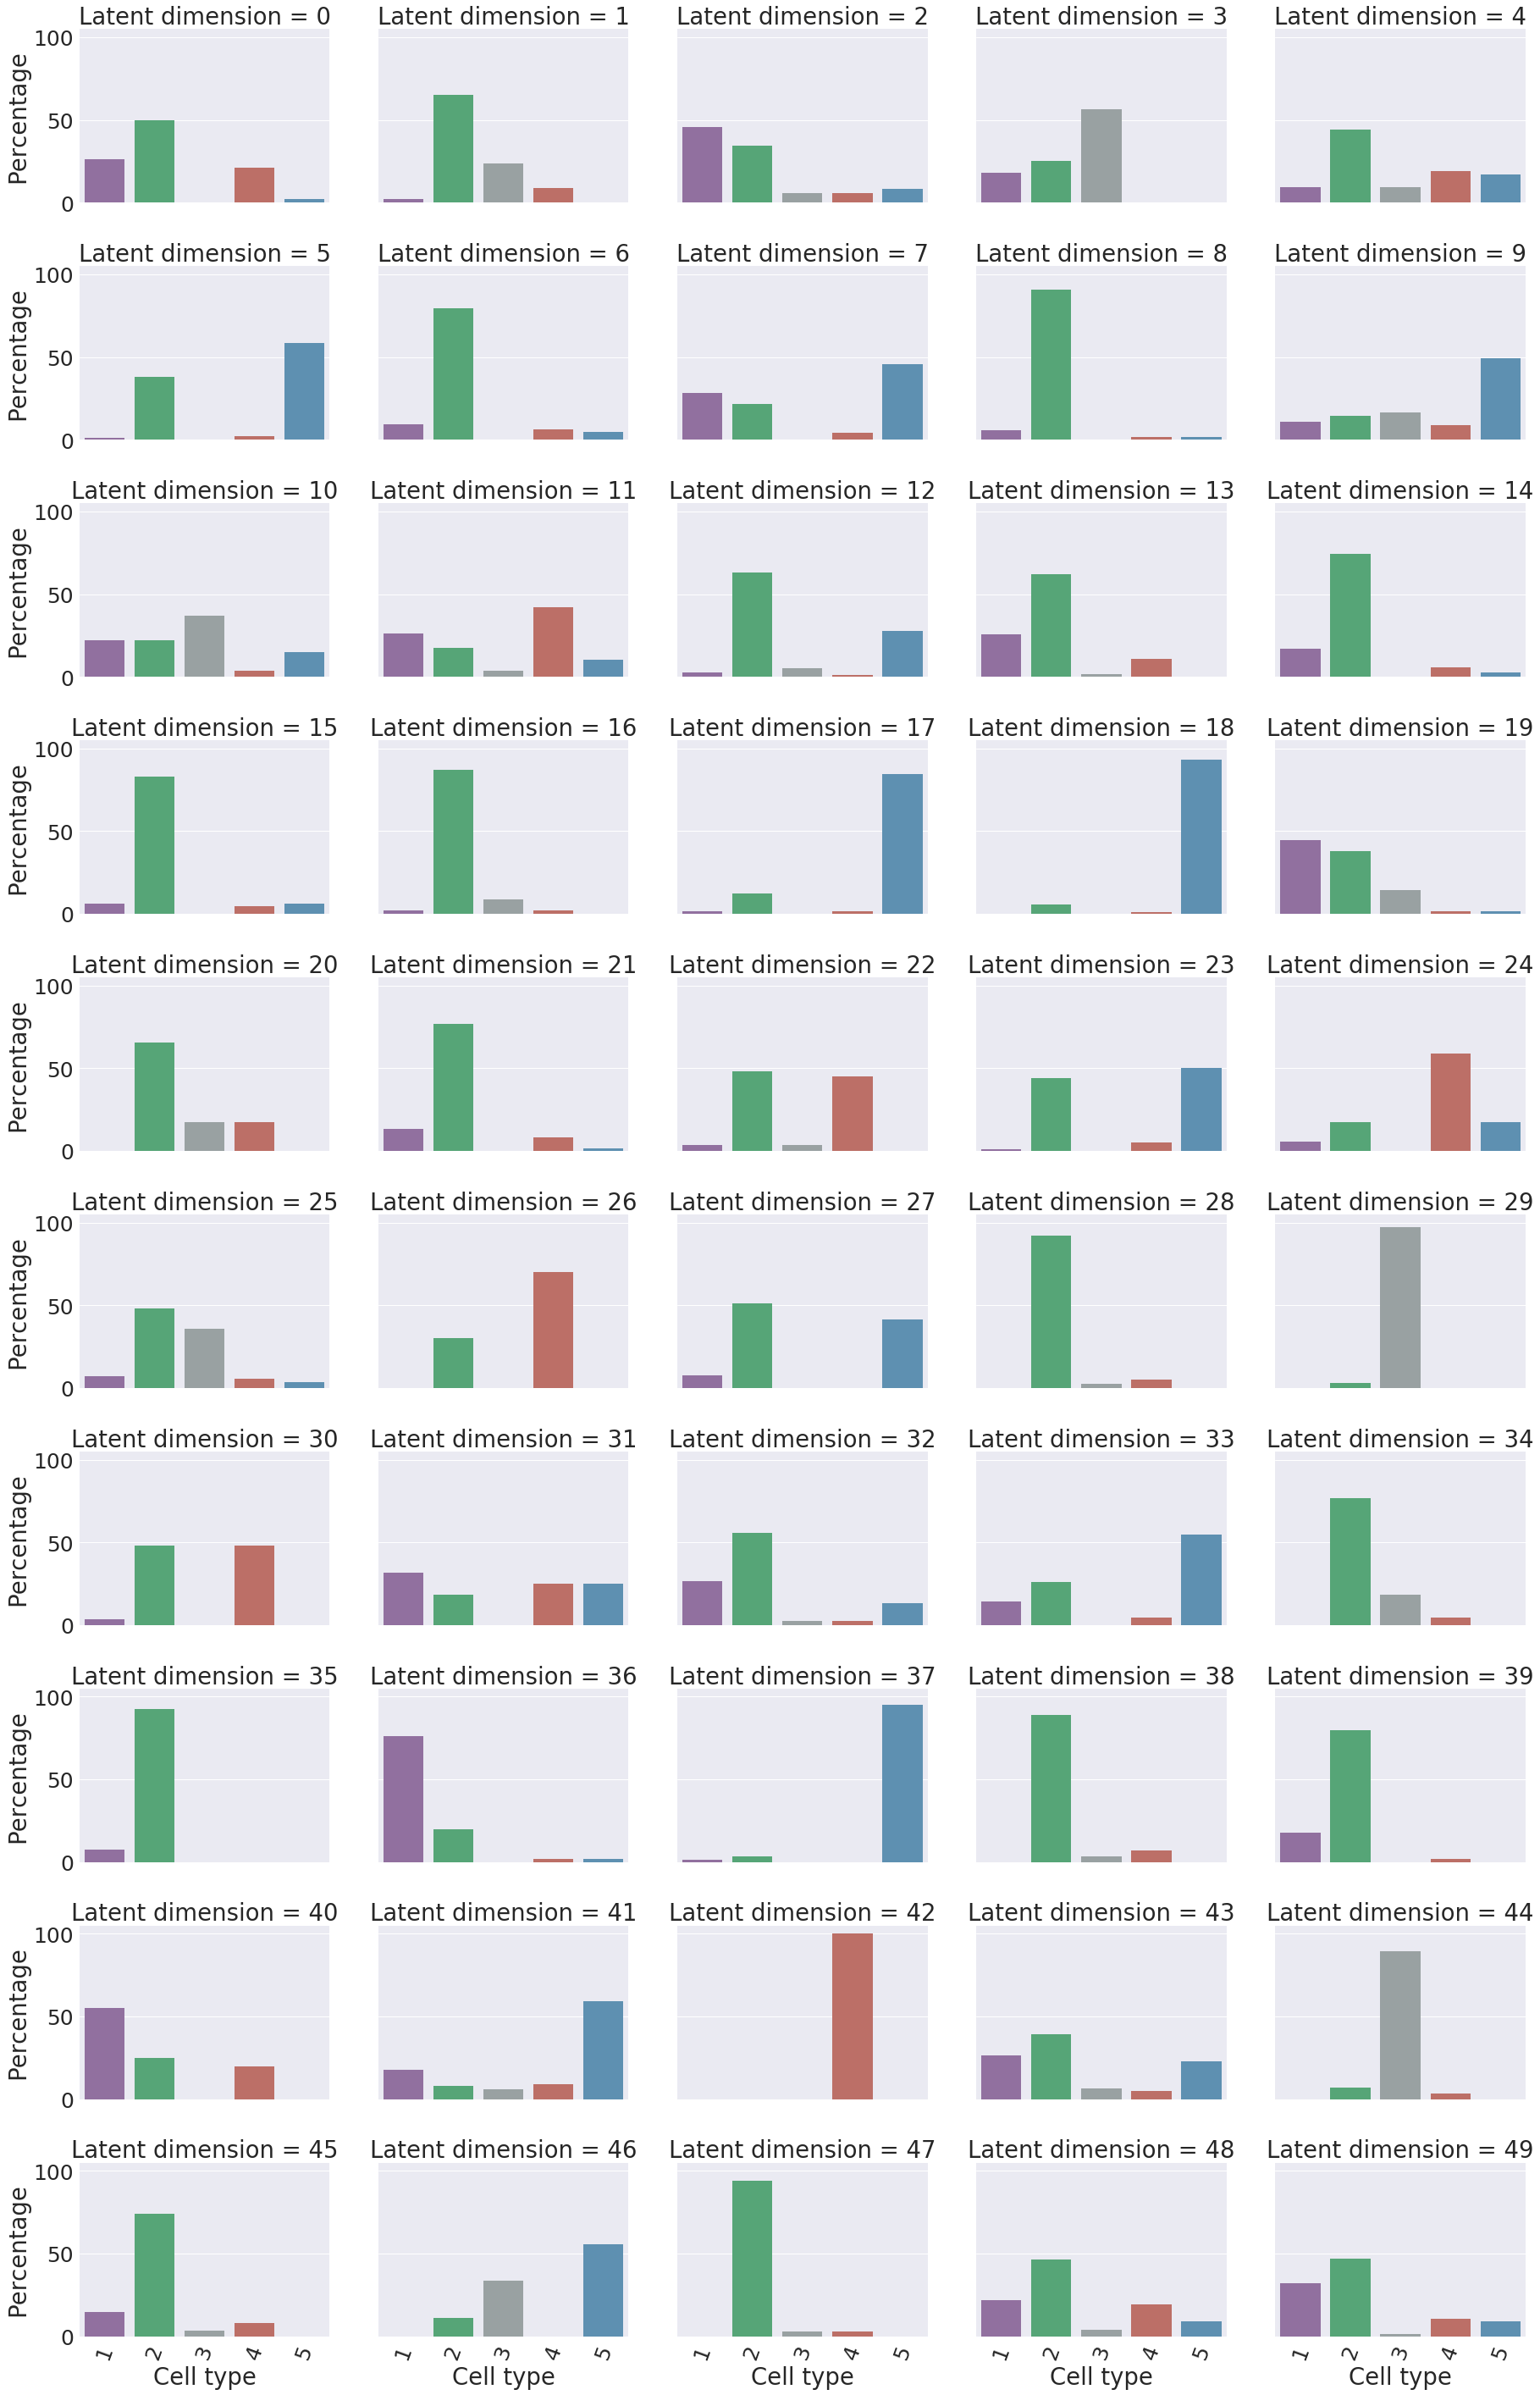

In [22]:
latent_diff=compute_diff_capacity_latent_dim(sample_enc_dis, labels_clusters[0,:], model='dis')

In [23]:
# identify those components that are relevant for some clusters 
Map_components_clusters=np.array([latent_diff['Latent dimension'][np.where(latent_diff['Percentage']>50.)[0]],
                                 latent_diff['Cell type'][np.where(latent_diff['Percentage']>50.)[0]]])
Map_comp_clust = pd.DataFrame(Map_components_clusters.T, columns=['Latent dimension', 'Cell type'])
#print(latent_diff['Latent dimension'][np.where(latent_diff['Percentage']>50.)[0]])
print(latent_diff['Cell type'][np.where(latent_diff['Percentage']>50.)[0]])


36     1
40     1
51     2
56     2
58     2
62     2
63     2
64     2
65     2
66     2
70     2
71     2
77     2
78     2
82     2
84     2
85     2
88     2
89     2
95     2
97     2
103    3
129    3
144    3
174    4
176    4
192    4
205    5
217    5
218    5
233    5
237    5
241    5
246    5
Name: Cell type, dtype: object


## Identify relevant genes for each cluster based on the weights of the VAE

In [24]:
from Clustering.relevant_genes_from_weights import get_weights_latent_genes, compare_genes

In [26]:
# read names of genes
genes = np.loadtxt('./Data/Zebrafish/CV_genes.csv',delimiter='\n', dtype=bytes).astype(str)
print(genes.shape)
genes_names=genes[1:]



(1846,)


In [27]:
# get the weights for all genes
W, W_abs=get_weights_latent_genes(model_dis, len(args.hidden_layers), args.encoding_dim, genes)
print(np.array(W).shape)

(50, 1845)


In [28]:
# get N most relevant genes for a specific cluster compare_genes(W_abs, cluster_number, N_most_relevant_genes, genes,Map_comp_clust)
Weights, Names, C= compare_genes(W_abs, 5, 10, genes, Map_comp_clust)
print(len(C))
print(C)

7
[['"773","ENSDARG00000038643,alas2,8,protein_coding"', '"1364","ENSDARG00000097238,ba1l,3,protein_coding"', '"571","ENSDARG00000097011,hbaa1,3,protein_coding"', '"45","ENSDARG00000034852,nt5c2l1,10,protein_coding"', '"1369","ENSDARG00000095304,si:ch211-207c6.2,5,protein_coding"', '"879","ENSDARG00000055781,ptger3,6,protein_coding"', '"302","ENSDARG00000012381,hsc70,15,protein_coding"', '"493","ENSDARG00000013110,dmtn,10,protein_coding"', '"944","ENSDARG00000089087,ba1,3,protein_coding"', '"805","ENSDARG00000041107,cftr,18,protein_coding"'], [], [], [], [], [], []]


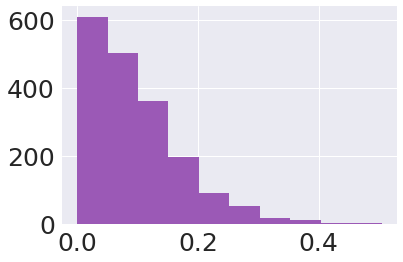

In [29]:
# weights distribution
plt.hist(abs(np.array(W)[8,:]))
plt.show()
#print(zebrafish_compute_high_weight_genes_latent_dim(W_abs, 8, genes).index.values)

## Plot gene expression for specific markers 

In [30]:
# Import markers from "golden list"
markers_0 = np.loadtxt('./Data/Zebrafish/dr_haem_markers2.csv',delimiter=',', dtype='str')
# Import GE
sample = dataset_train.x_data.to(device)
sample2=sample.cpu().detach().numpy()
#import names of the markers
imp_genes_name=markers_0[1:,2]
genes_names = np.loadtxt('./Data/Zebrafish/CV_genes_1.csv',delimiter=',', dtype=bytes).astype('str')

In [31]:
# Create labels for each cell according to the marker genes
print (imp_genes_name.shape)
markers_indexes=[]
markers_labels=[]
for i in imp_genes_name:
    if (np.where(genes_names[:,1]=='"'+str(i))[0].shape[0] != 0):
        markers_indexes.append(np.where(genes_names[:,1]=='"'+str(i))[0][0])
        markers_labels.append(sample2[:,np.where(genes_names[:,1]=='"'+str(i))[0][0]])

markers_labels=np.array(markers_labels)
markers_indexes=np.array(markers_indexes)  
print(genes_names[markers_indexes,:][:,2])



(133,)
['CD37' 'cd74a' 'ccr9a' 'mhc2dab' 'mpx' 'gata2a' 'ba1' 'csf3r' 'mpeg1.1'
 'cpa5' 'cd22' 'lyz' 'mpx' 'nitr2b' 'ccr7' 'cd4' 'nkiras1' 'gp1bb' 'itga2b'
 'mpl' 'rca2.1' 'selp' 'cd82a' 'cd82a' 'selp' 'cd74a' 'cd74a' 'tfr1b' 'ba1'
 'itga2b' 'mpl' 'tfr1b' 'gp1bb' 'CD68' 'nt5e' 'mpl' 'rhag']


/home/ha376/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


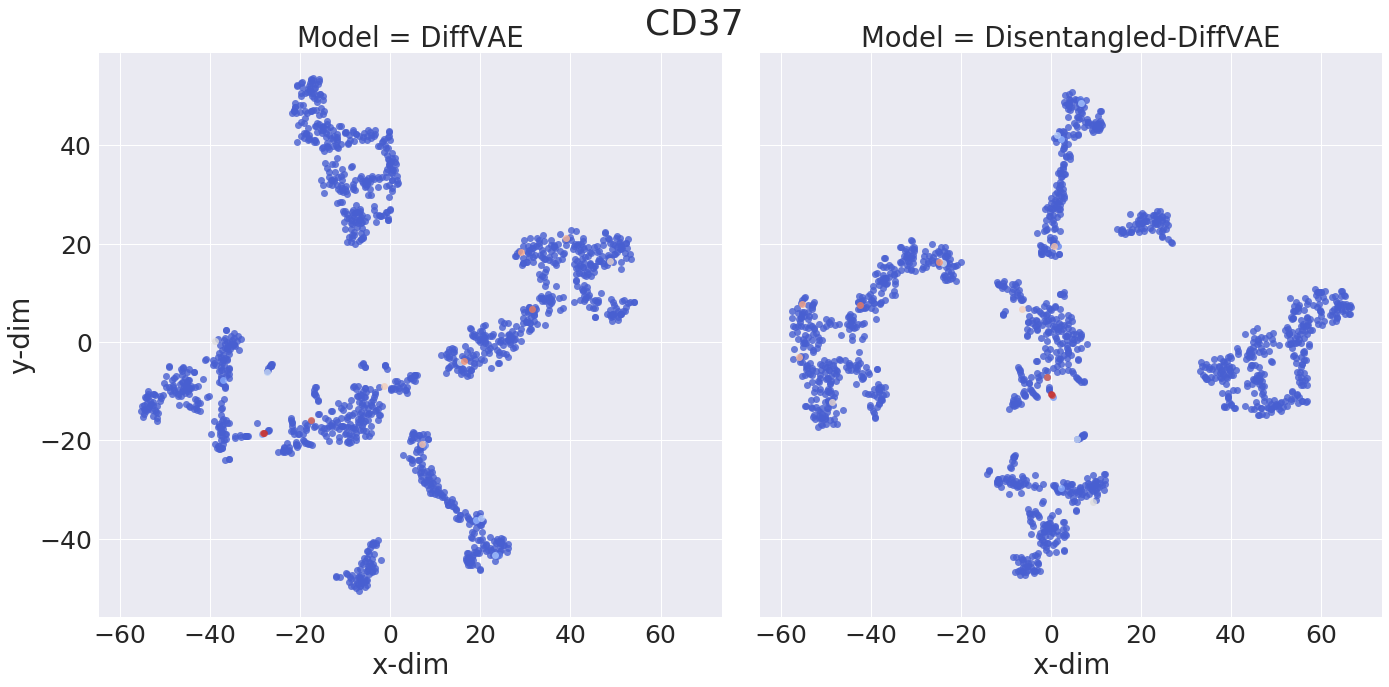

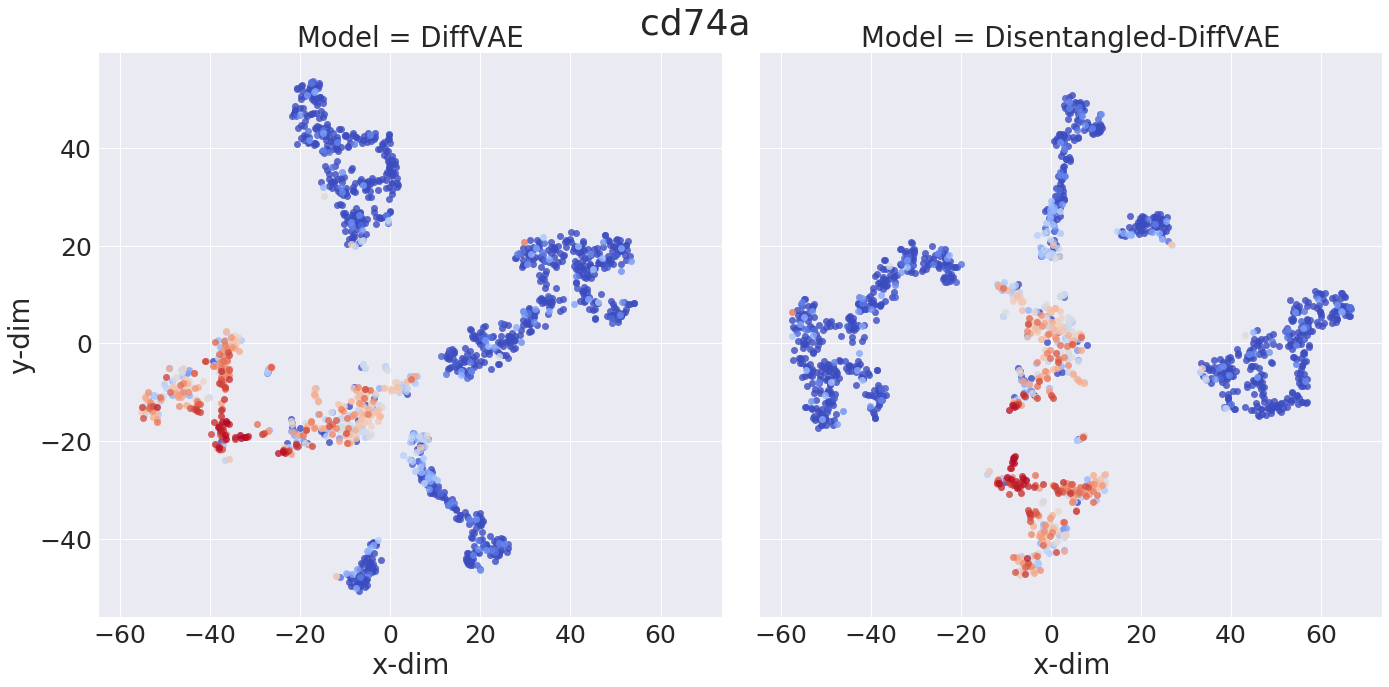

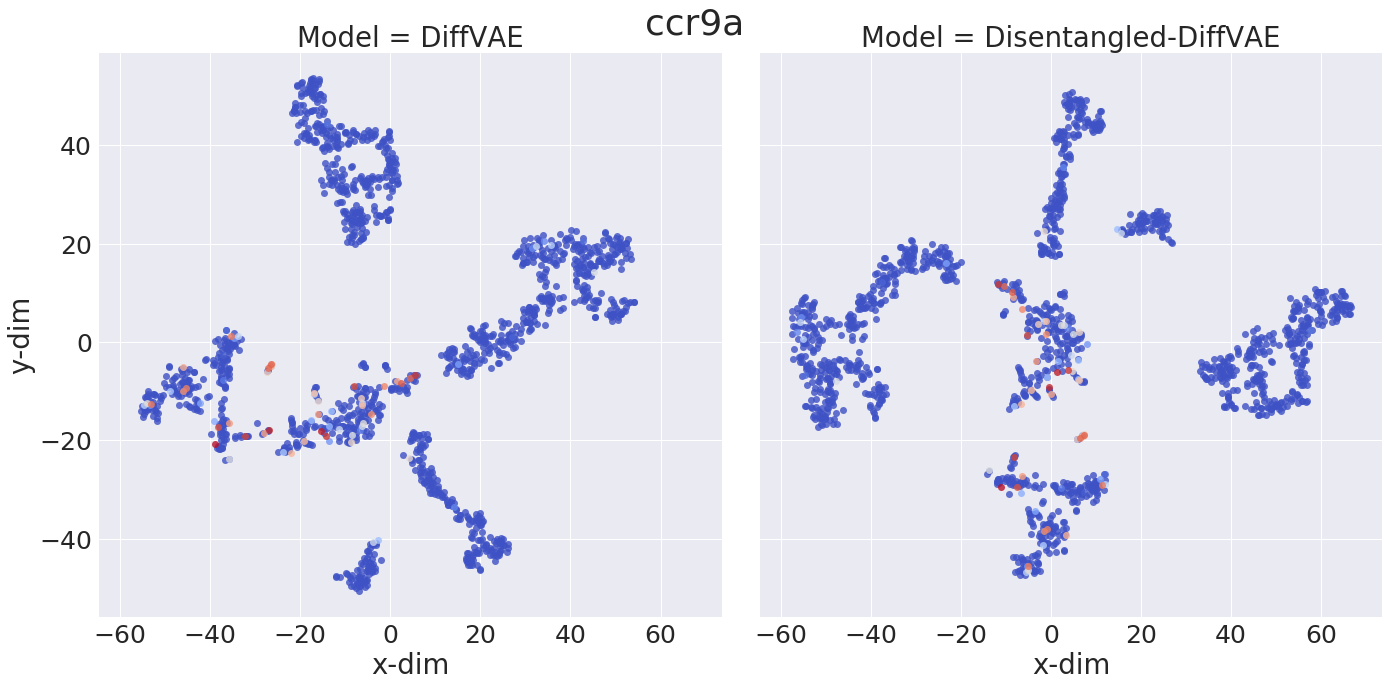

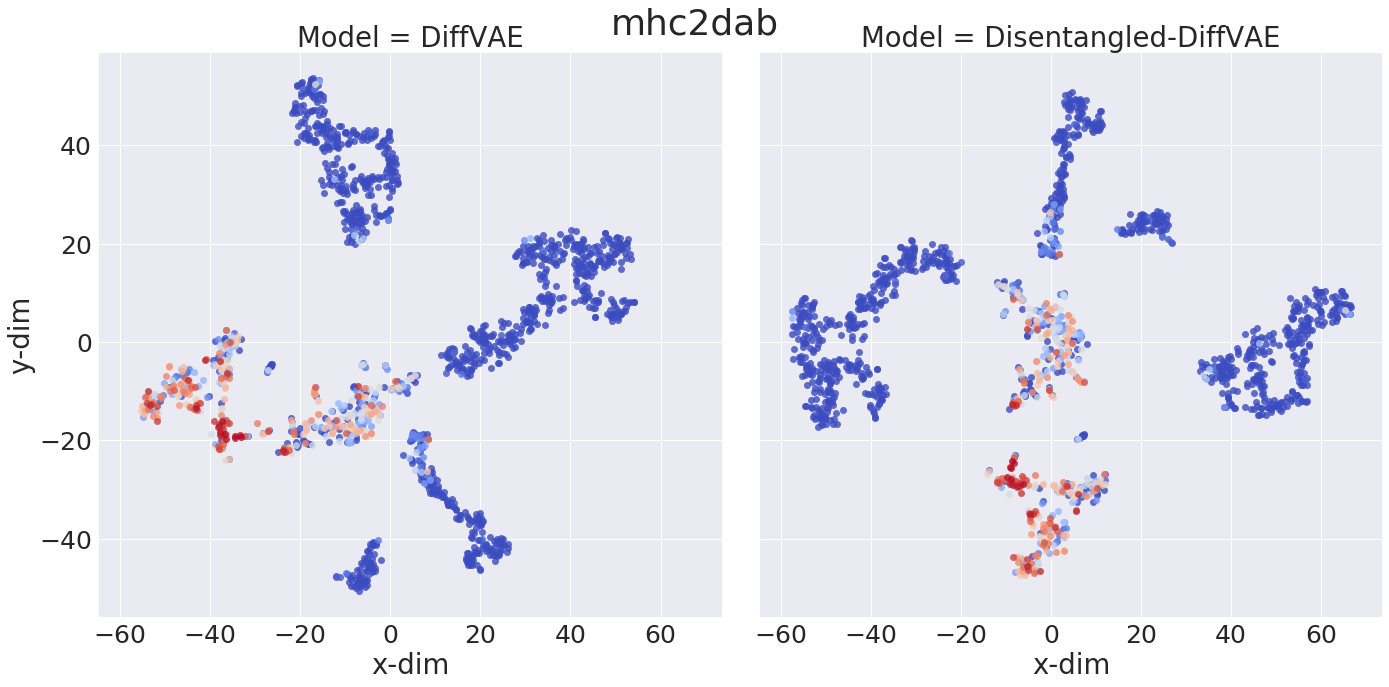

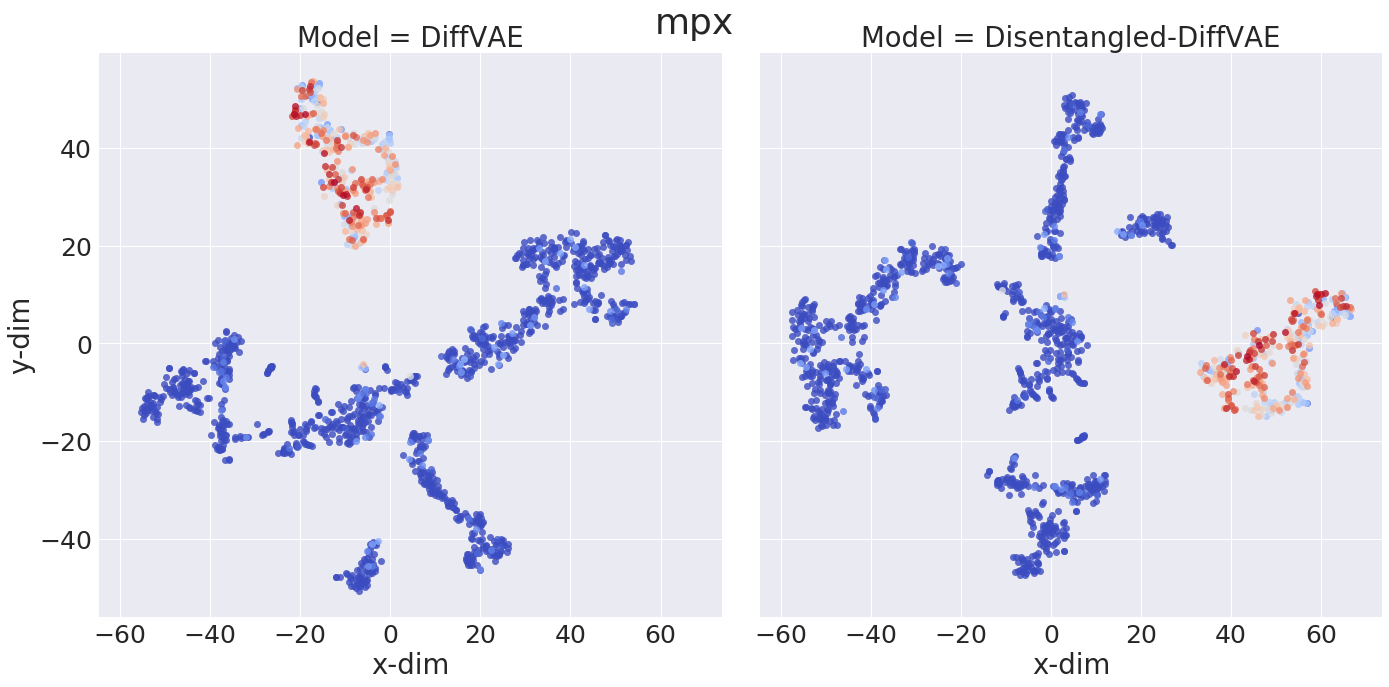

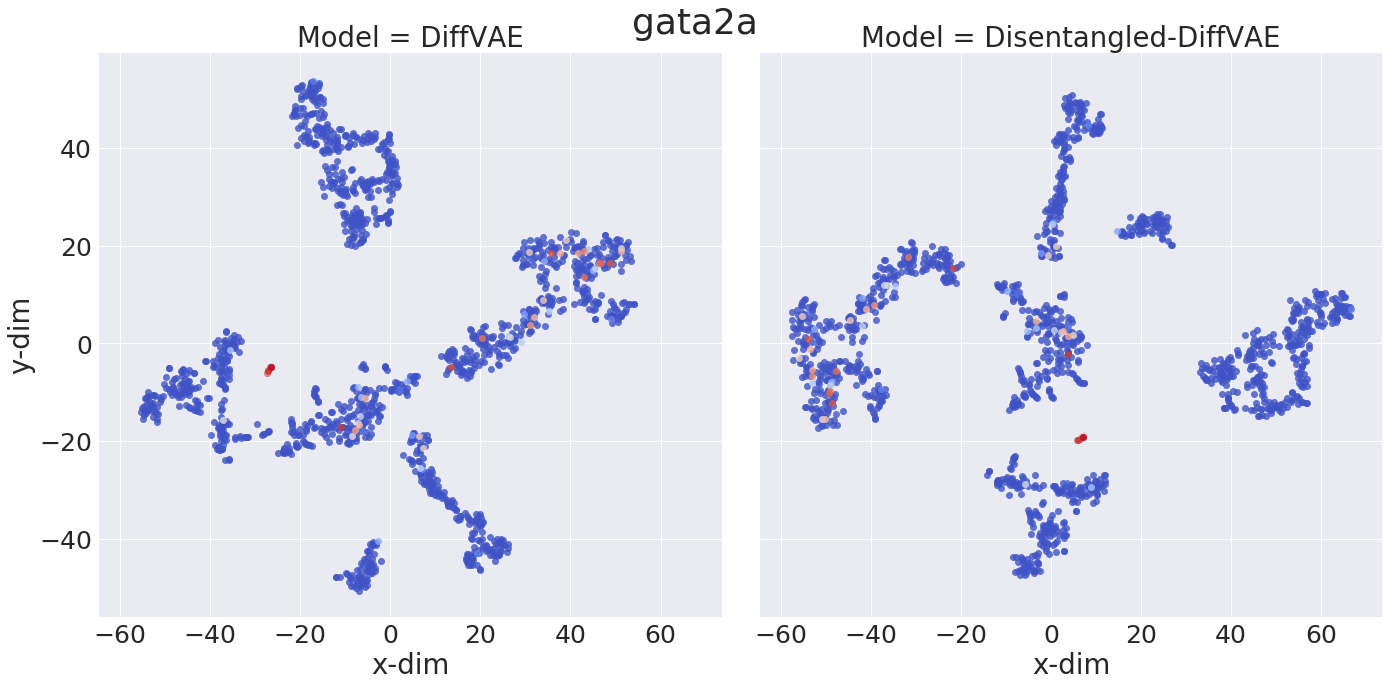

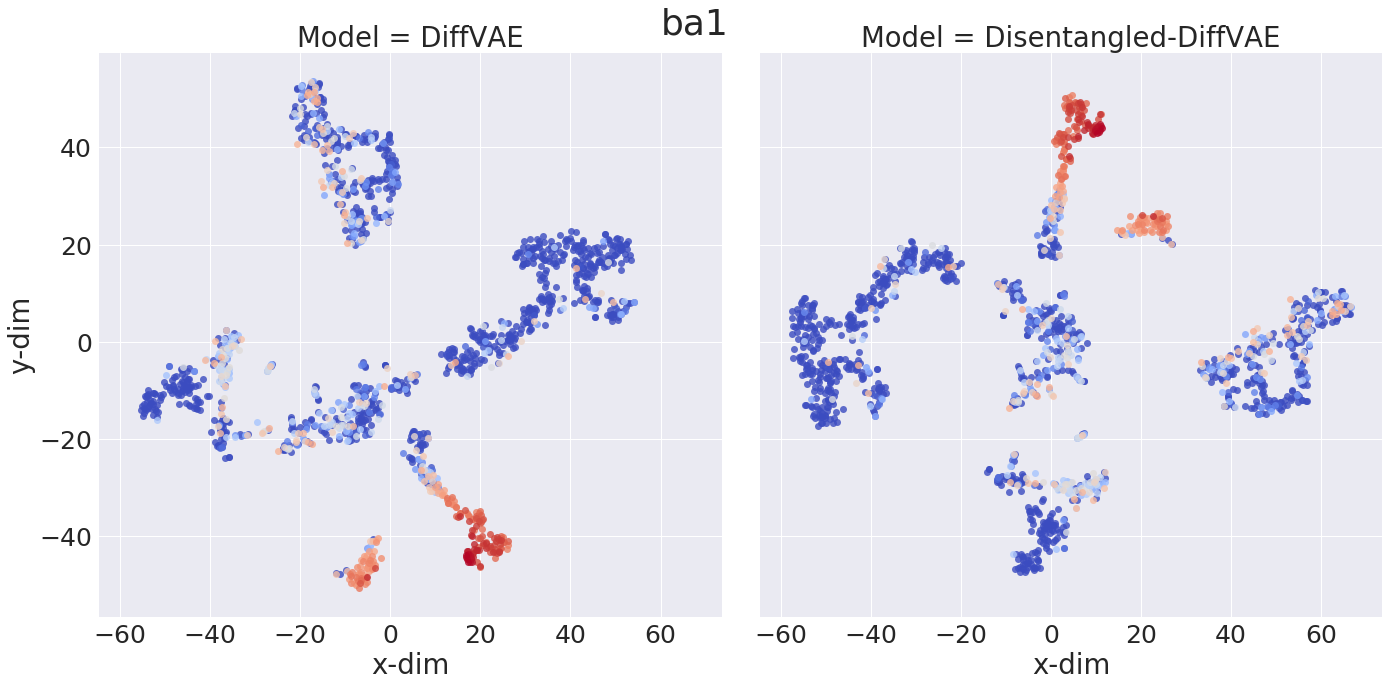

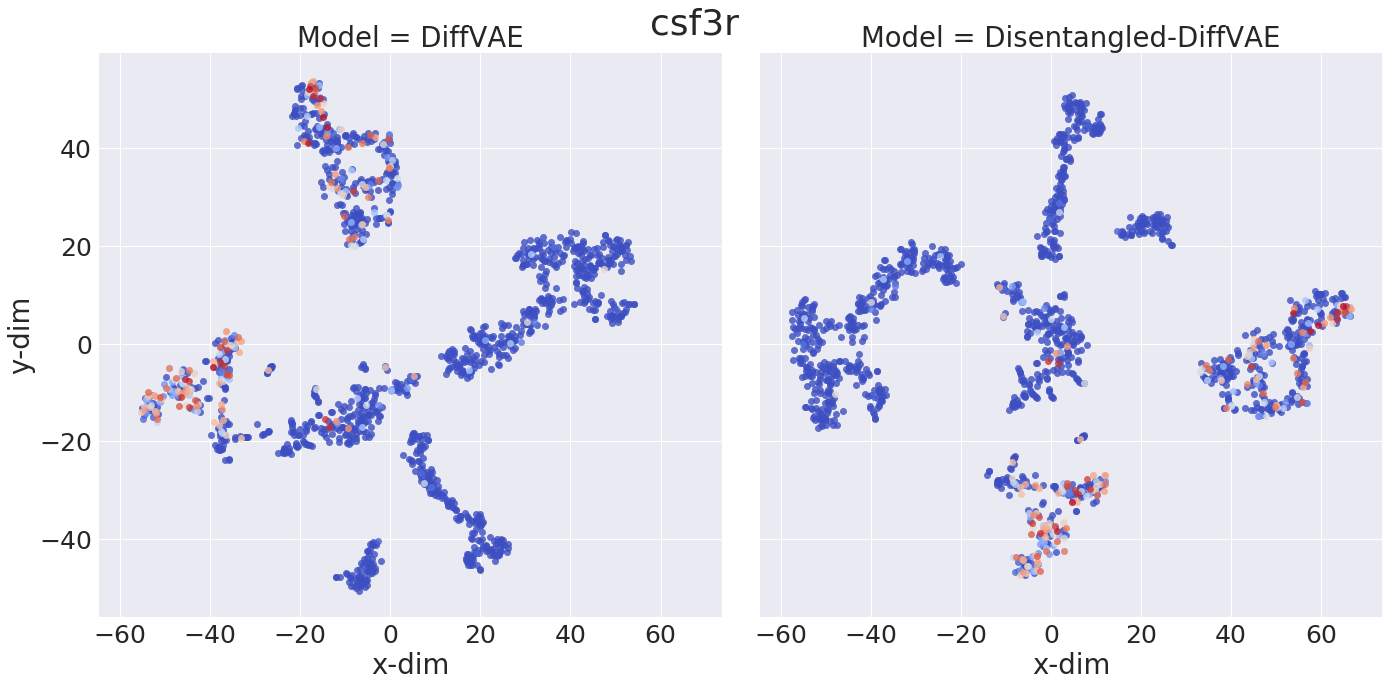

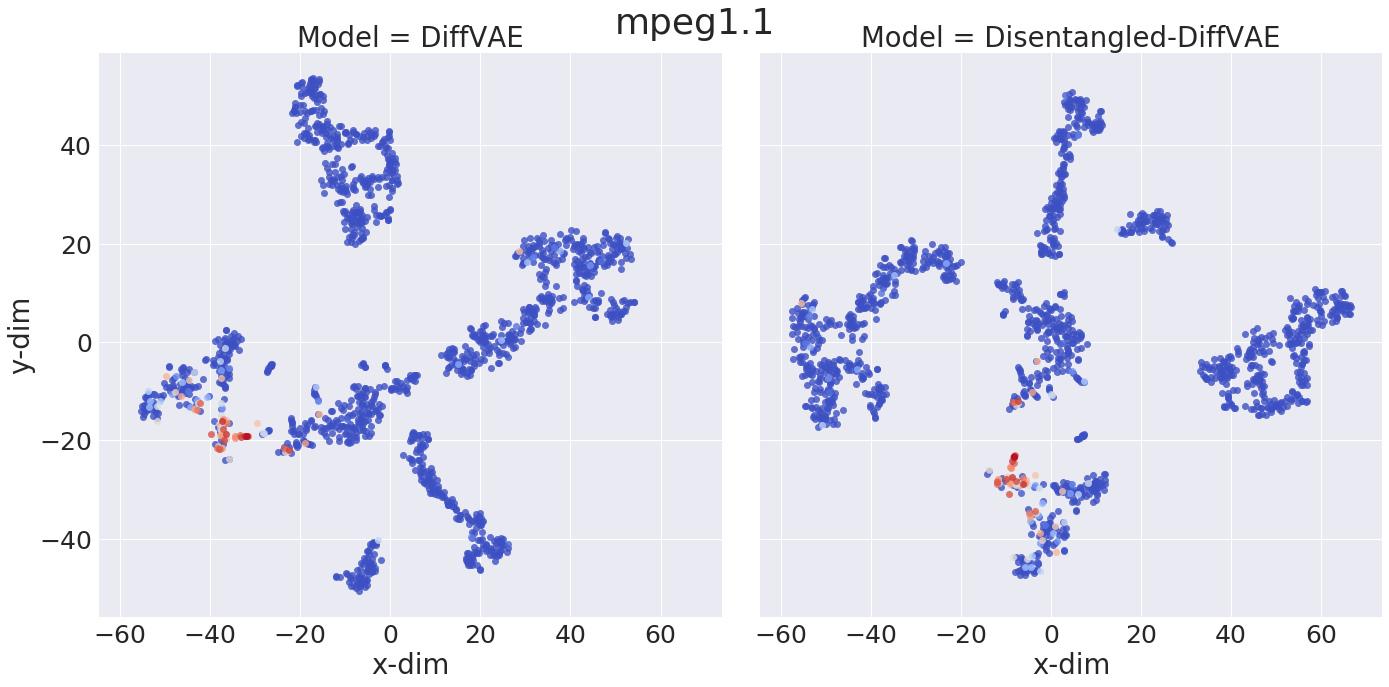

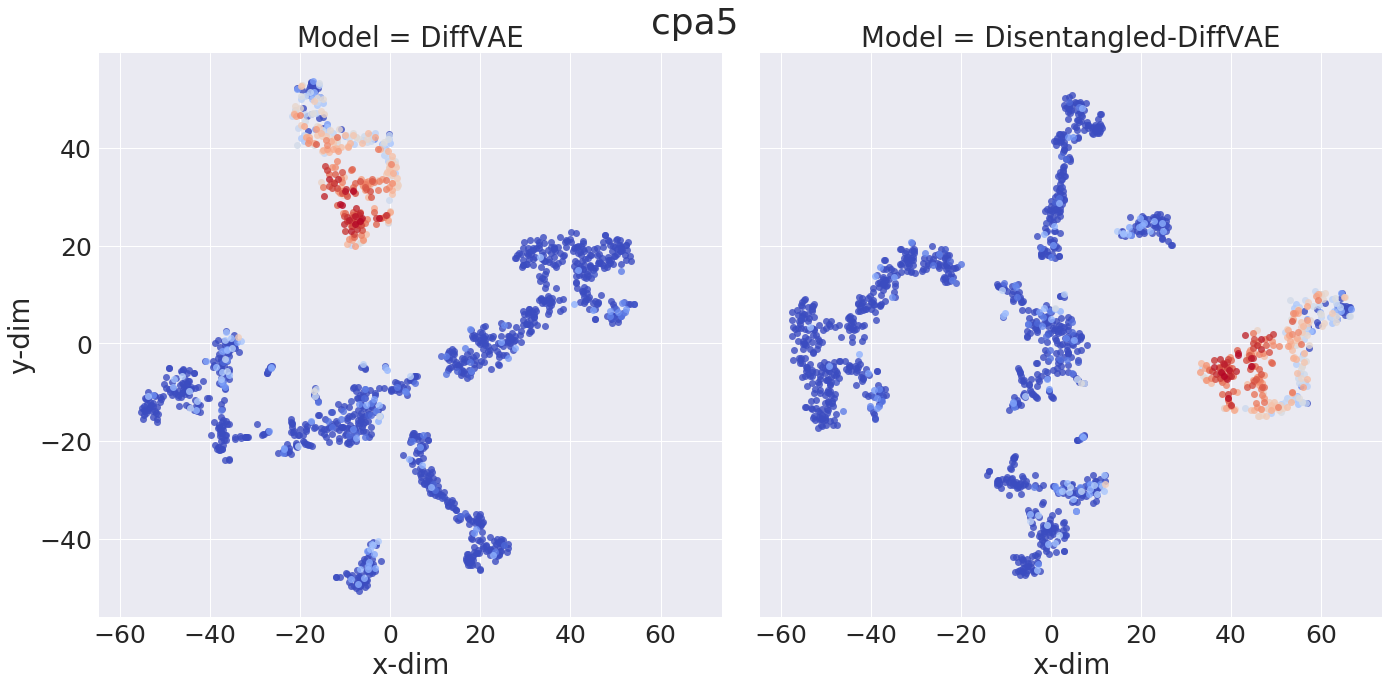

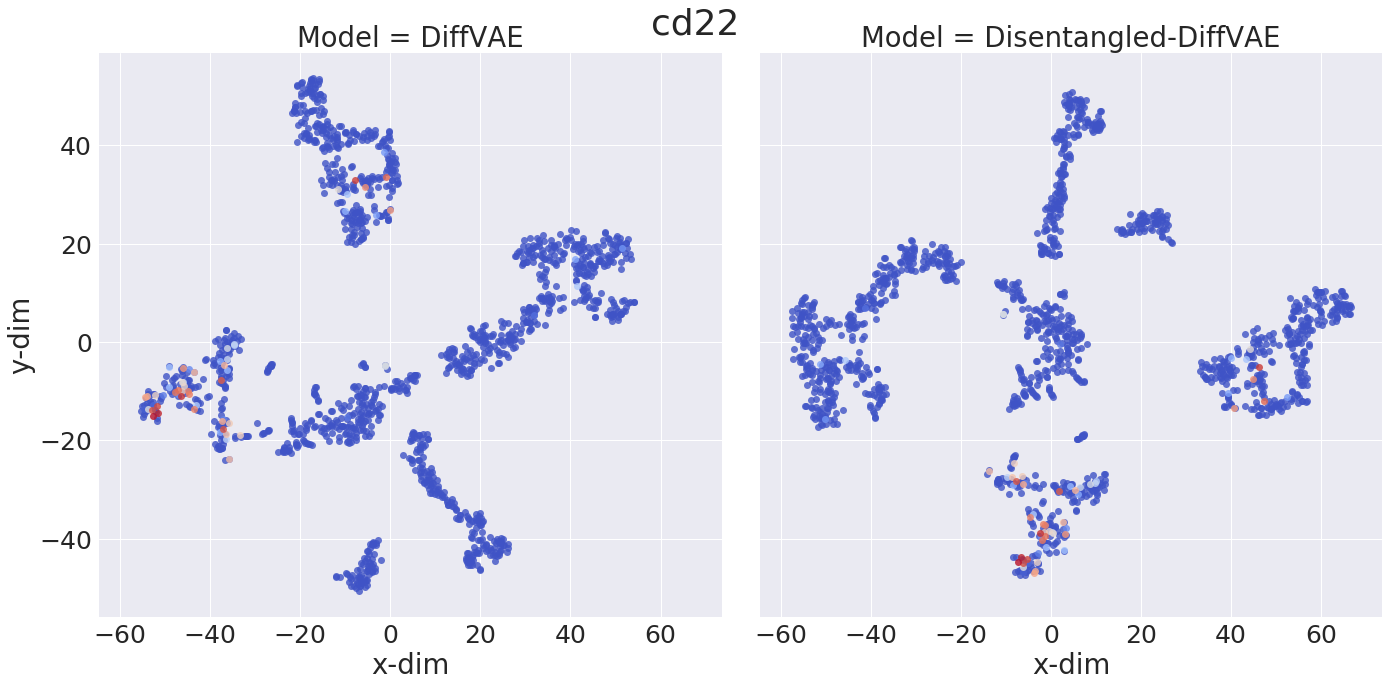

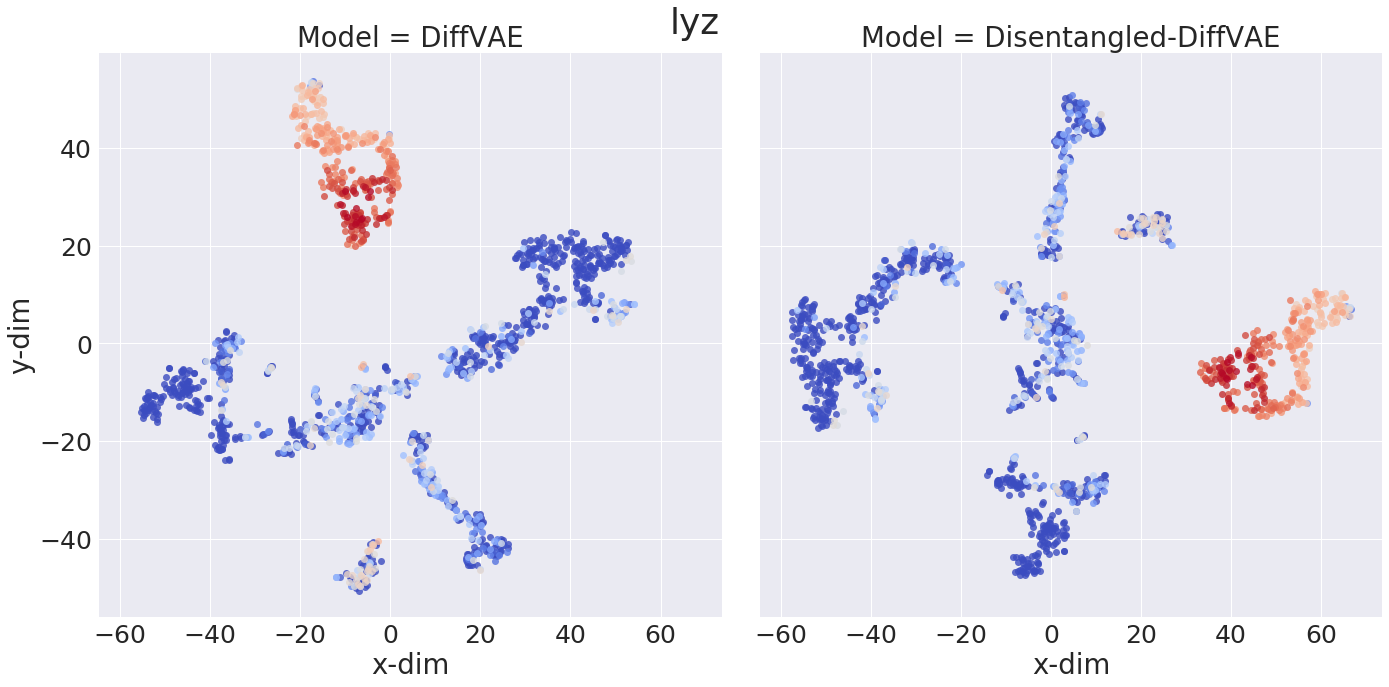

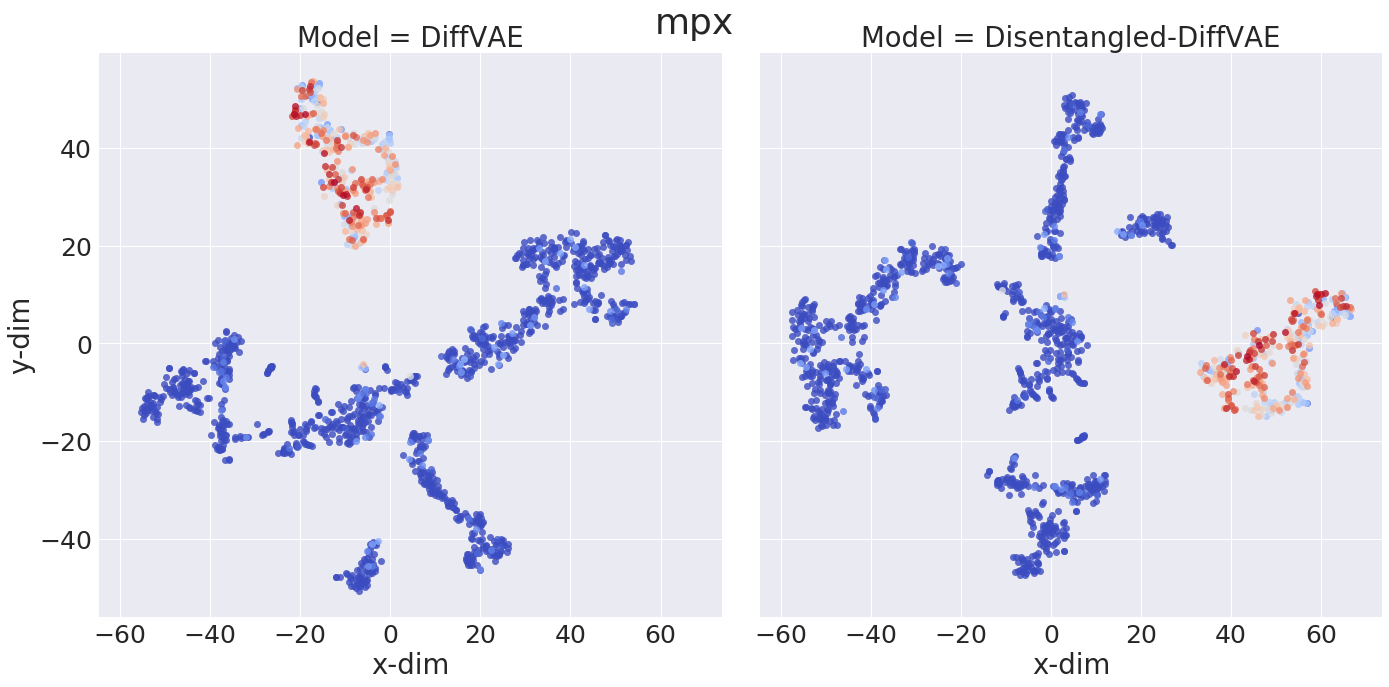

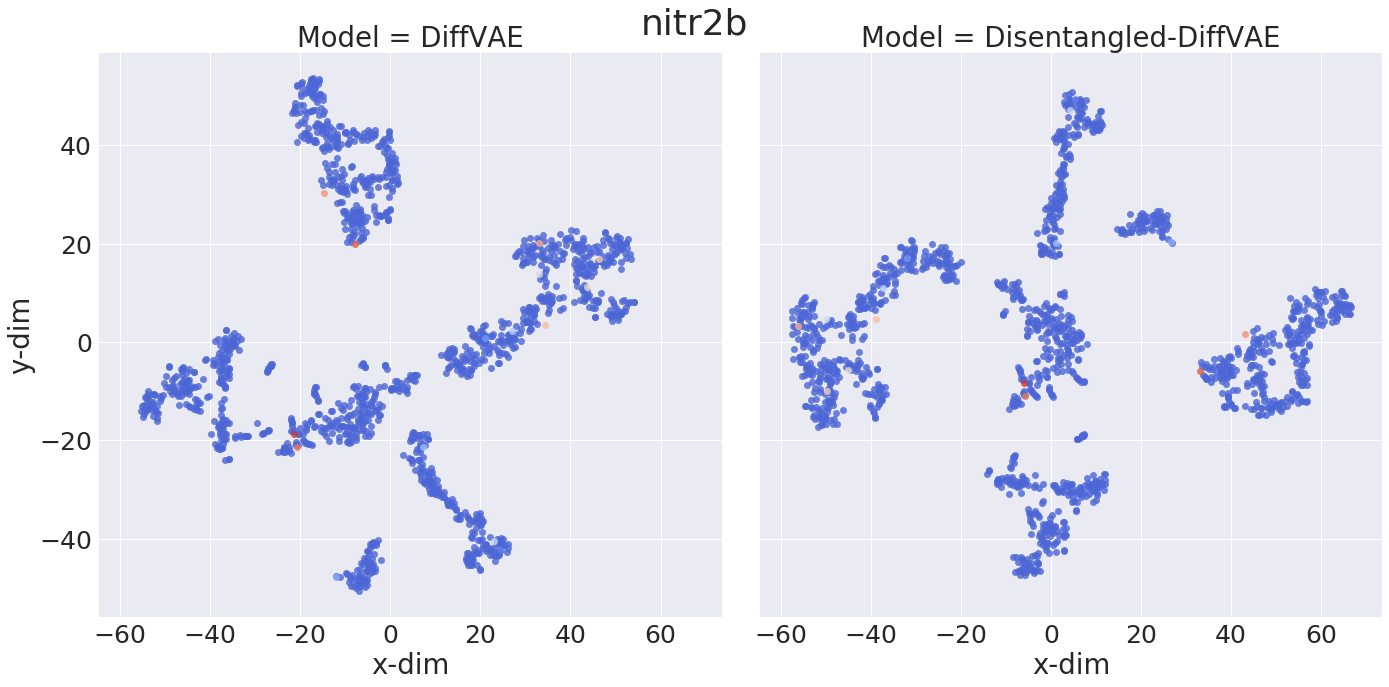

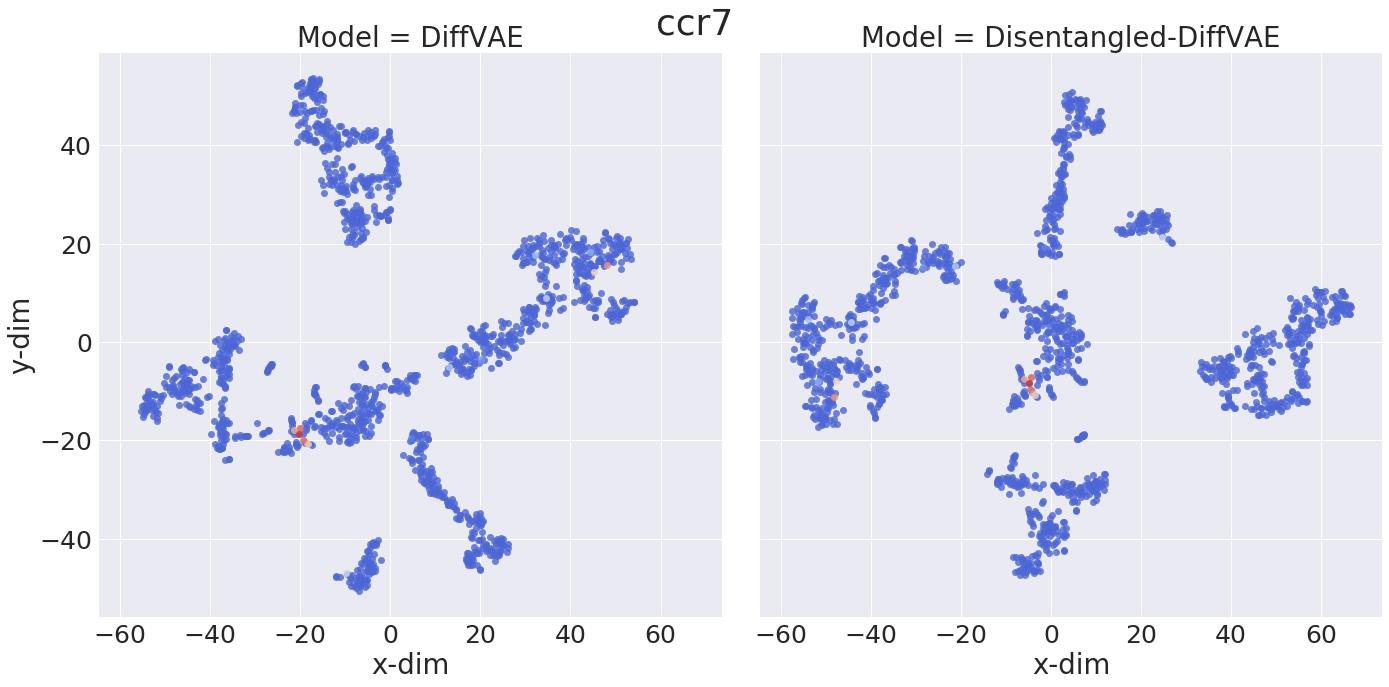

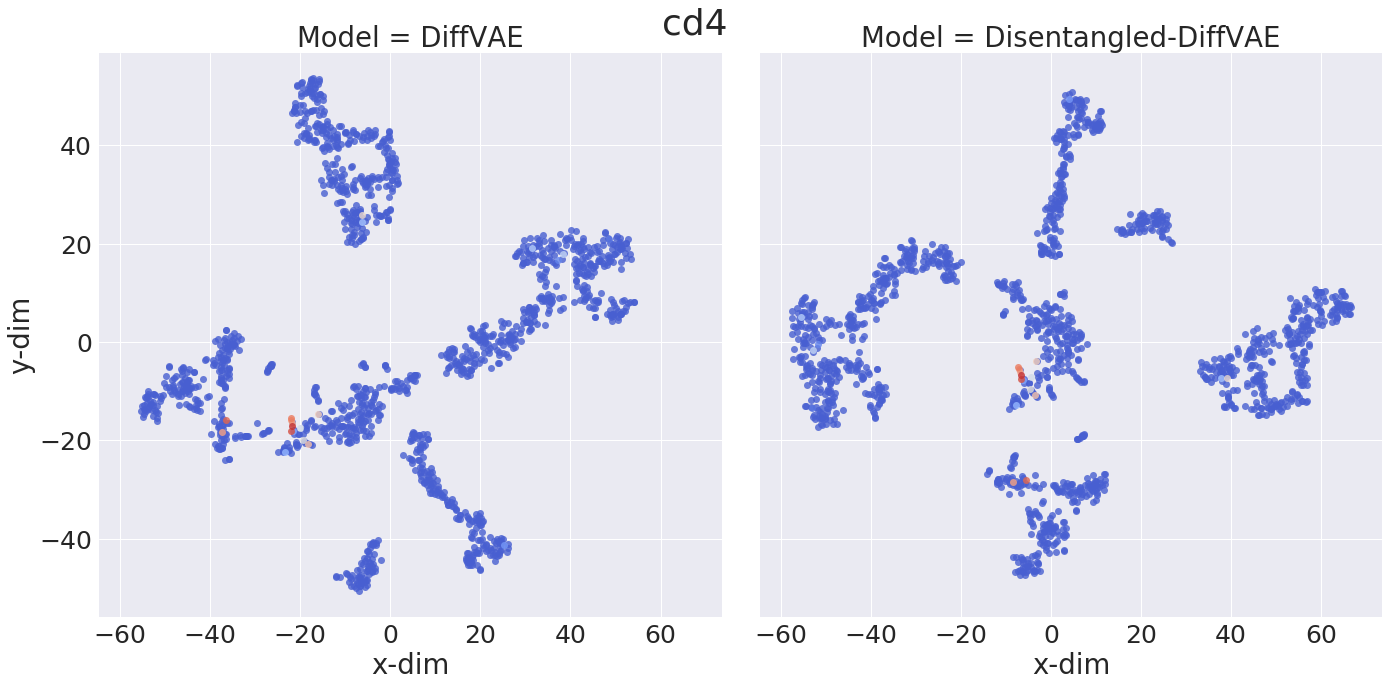

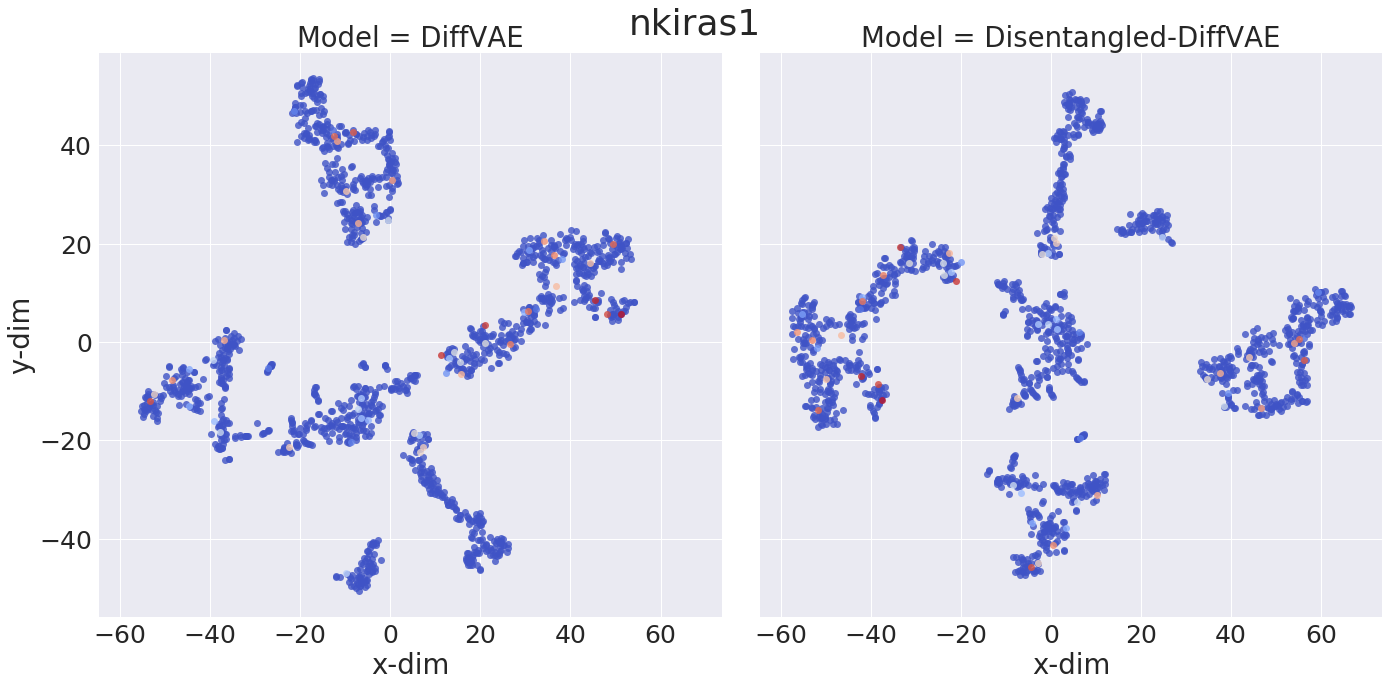

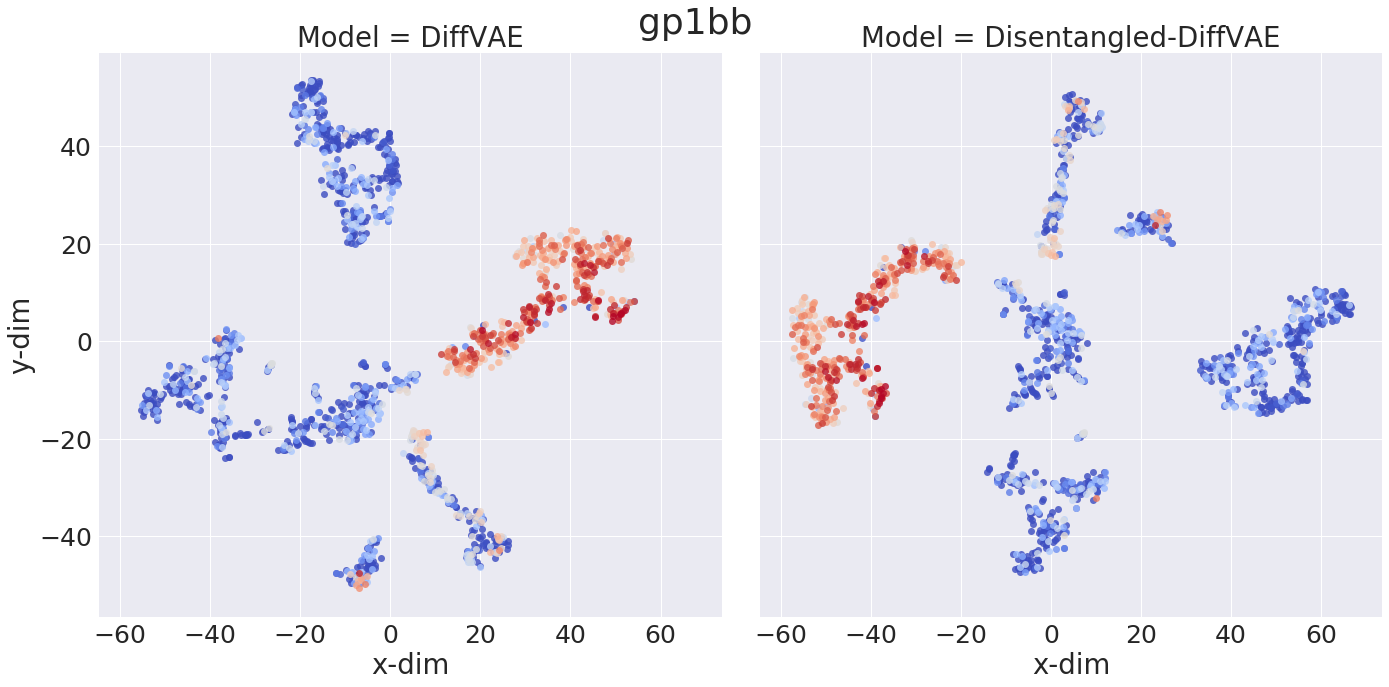

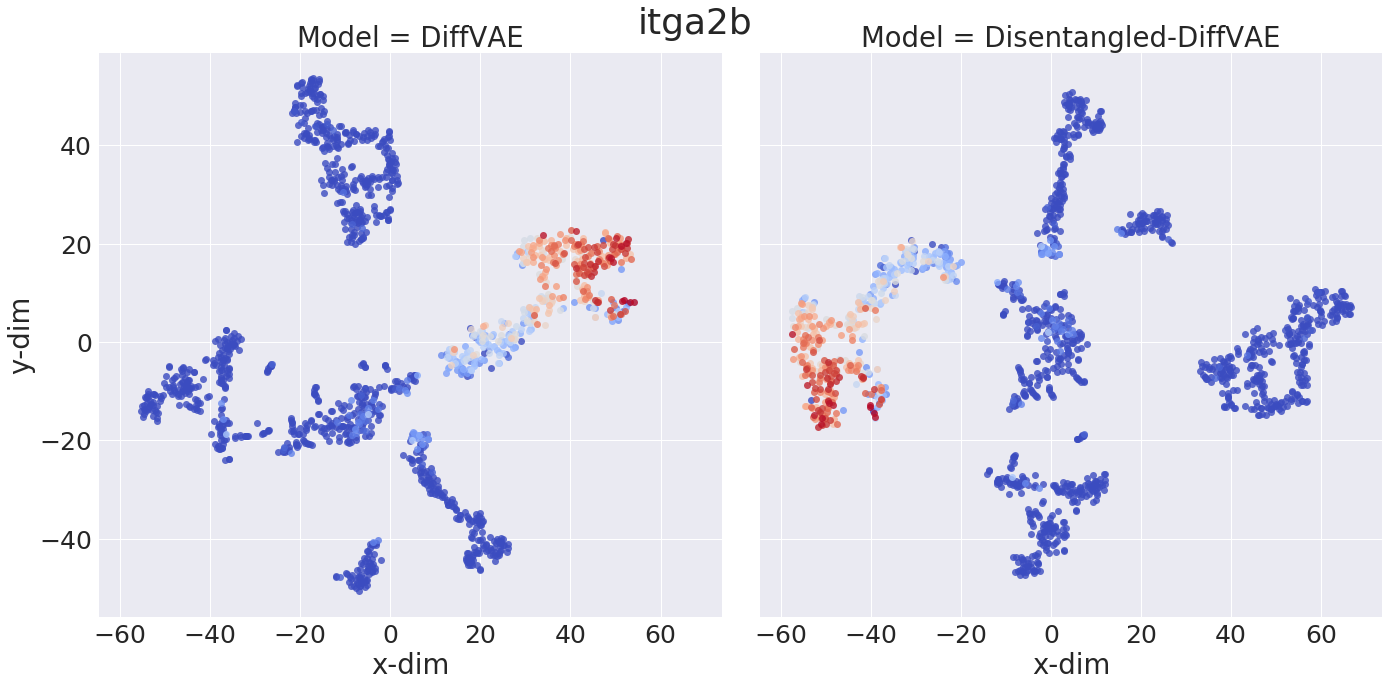

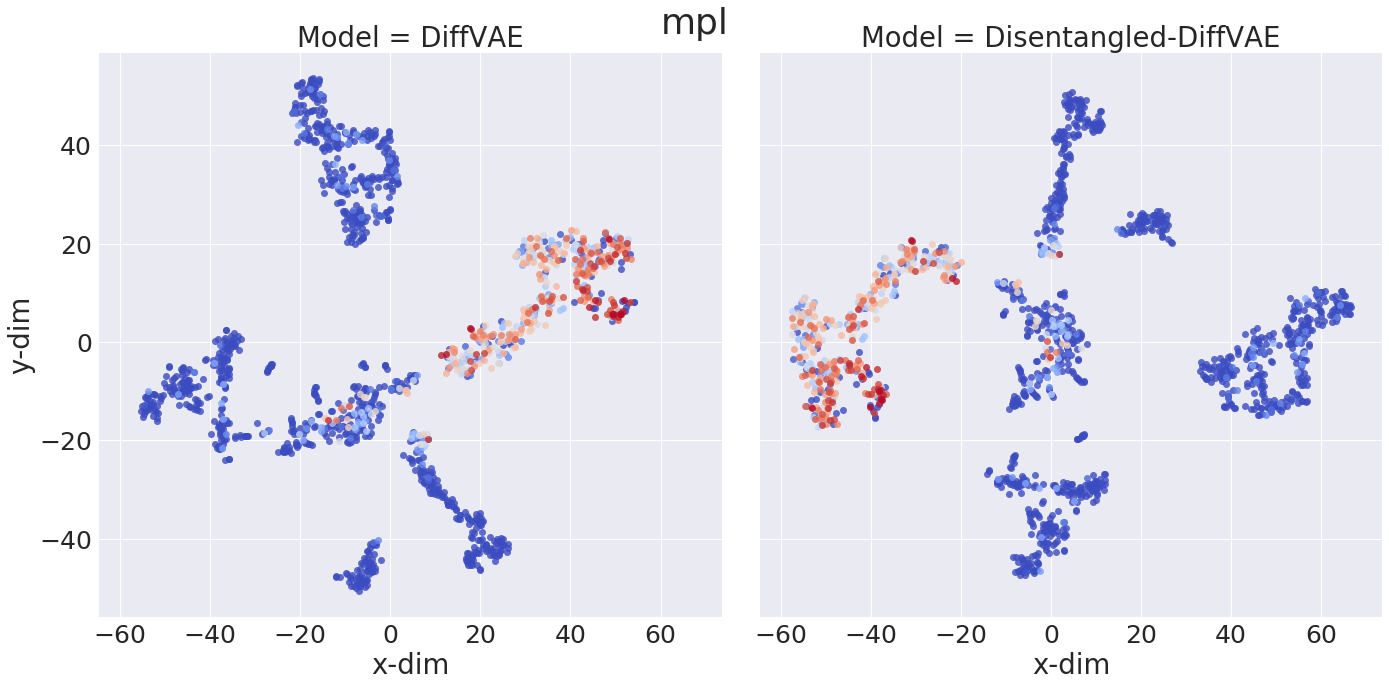

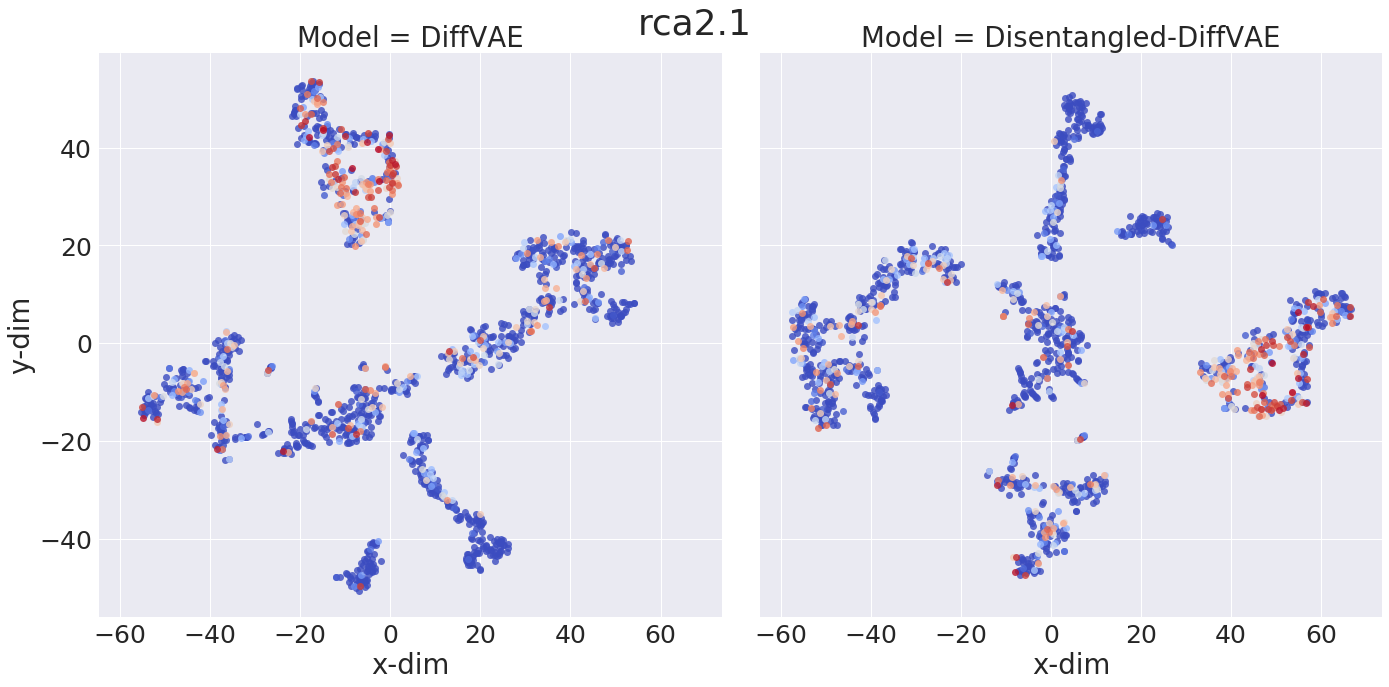

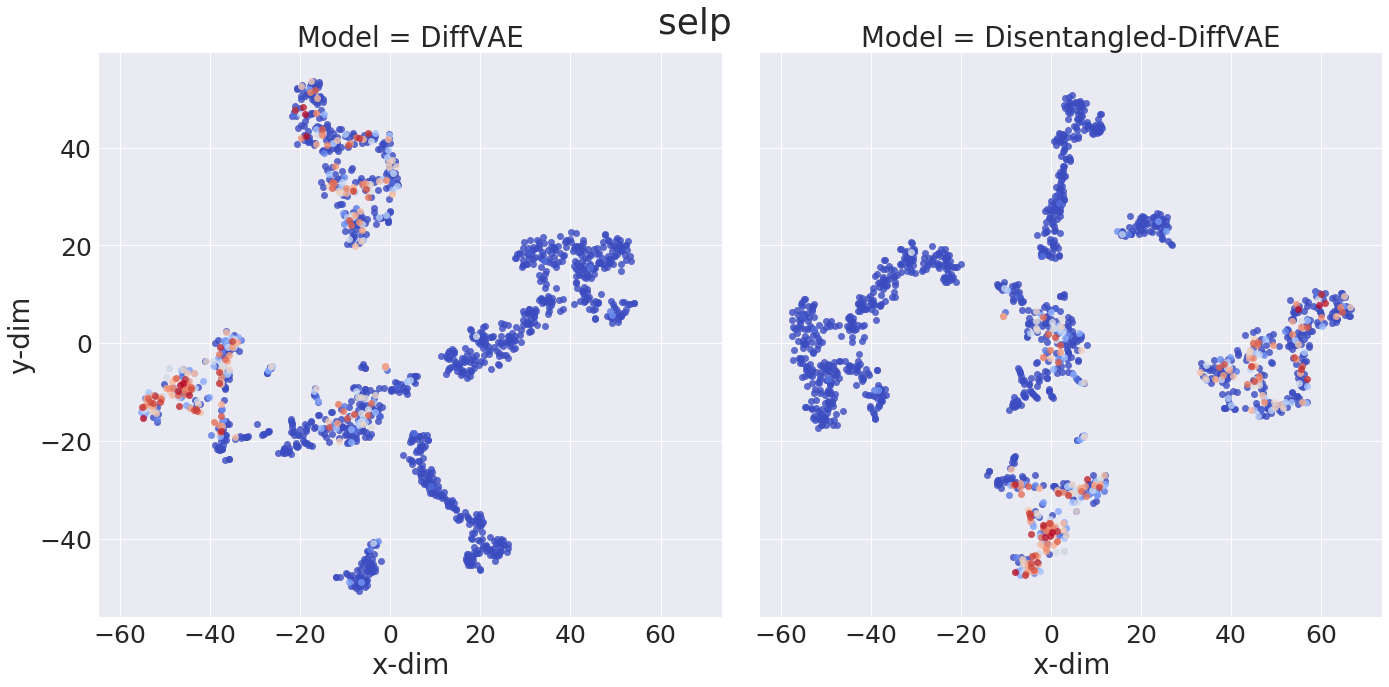

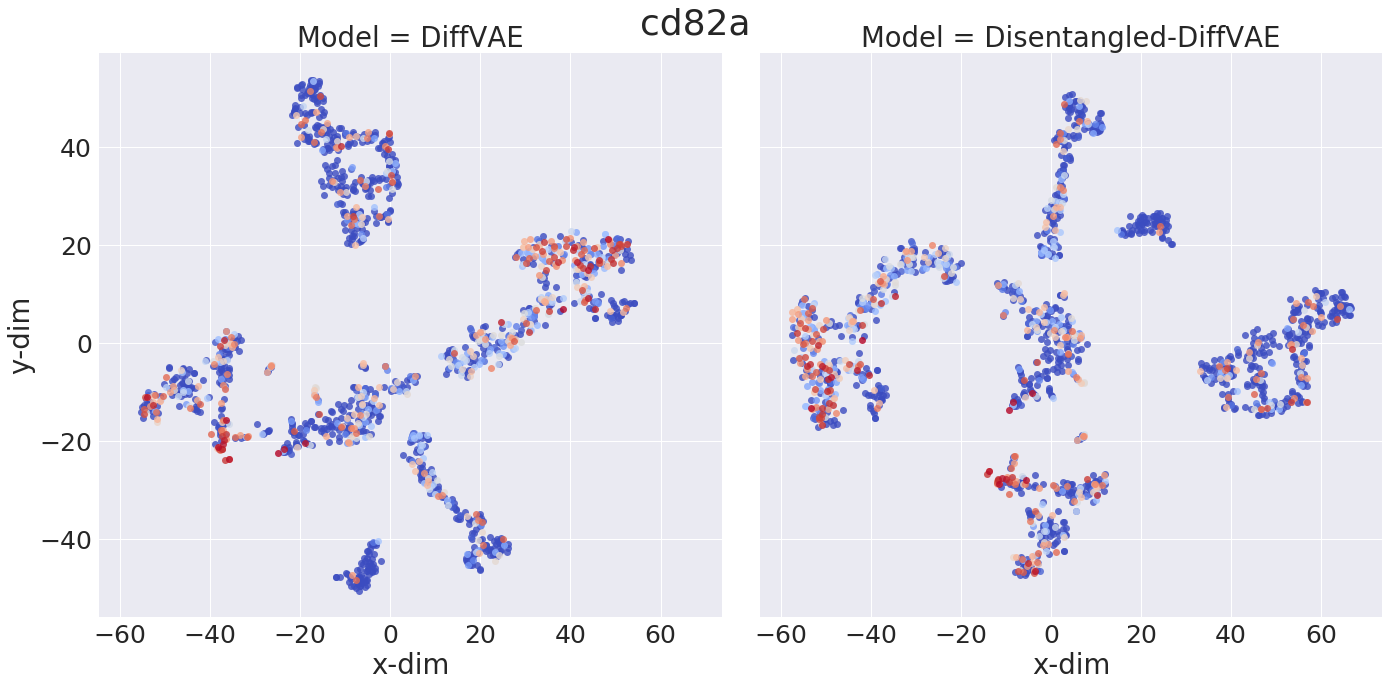

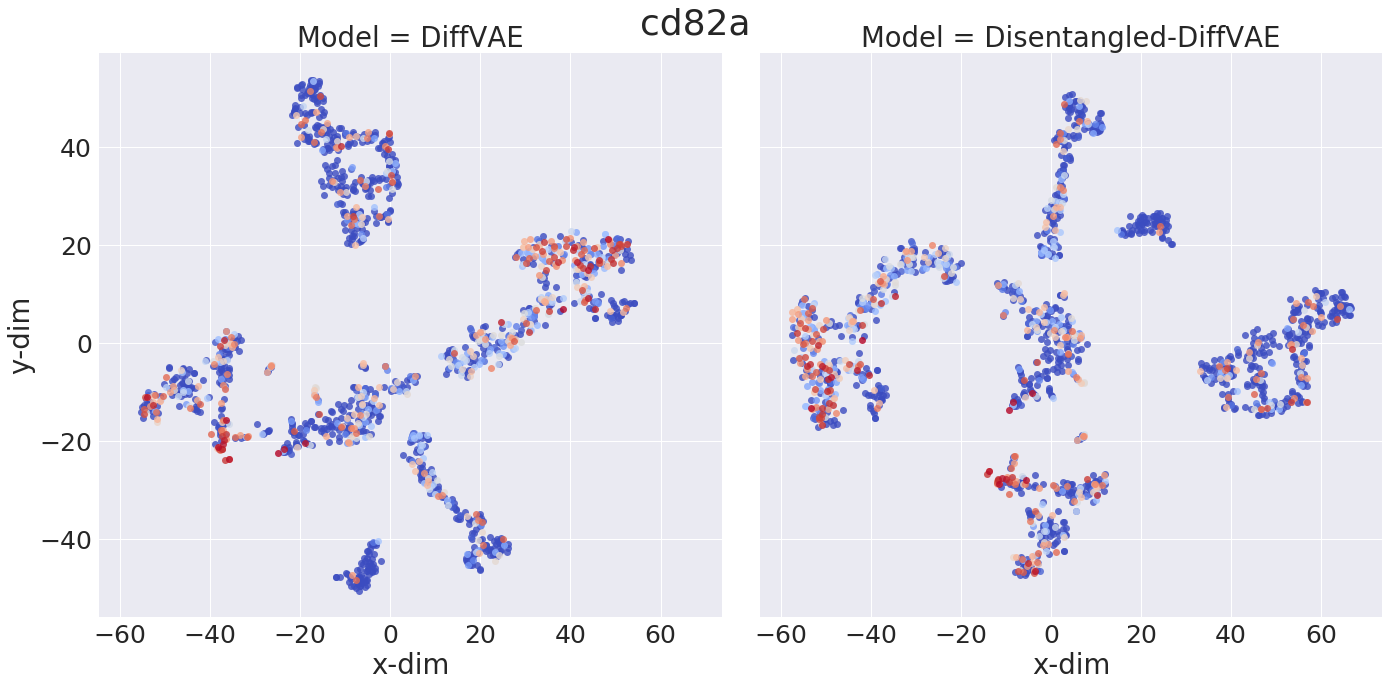

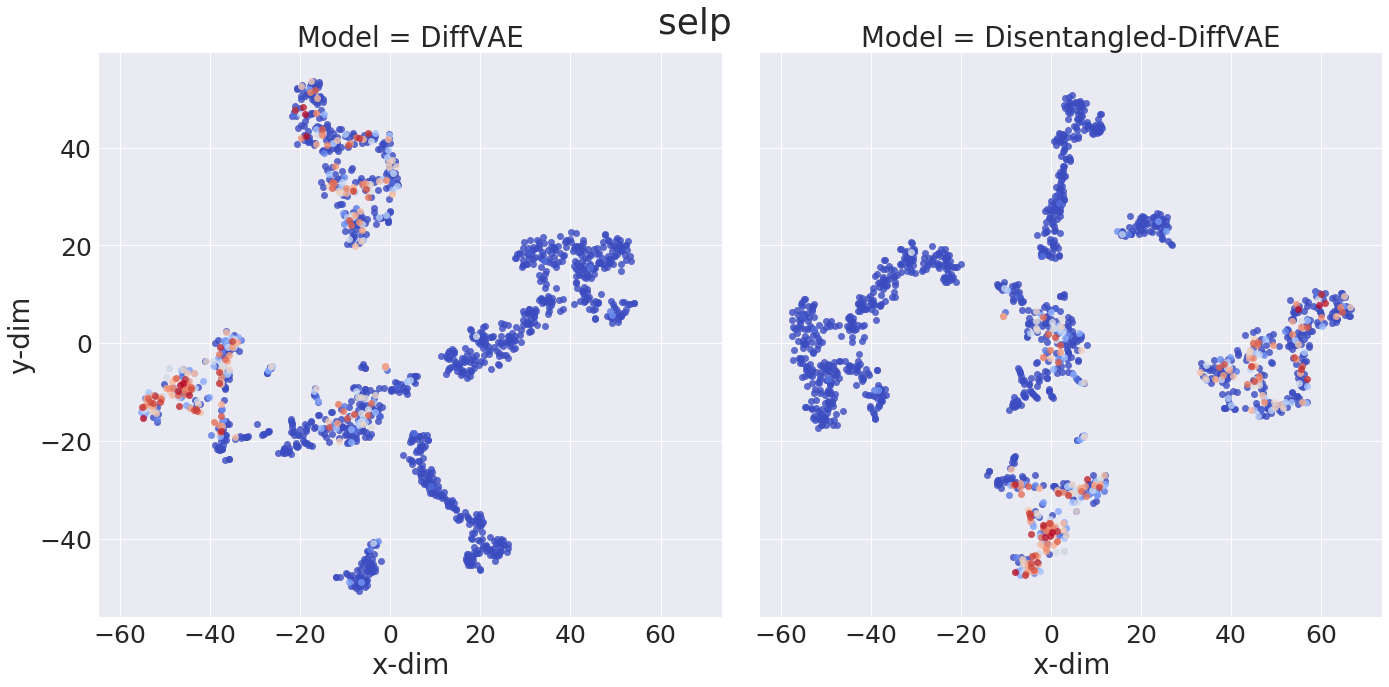

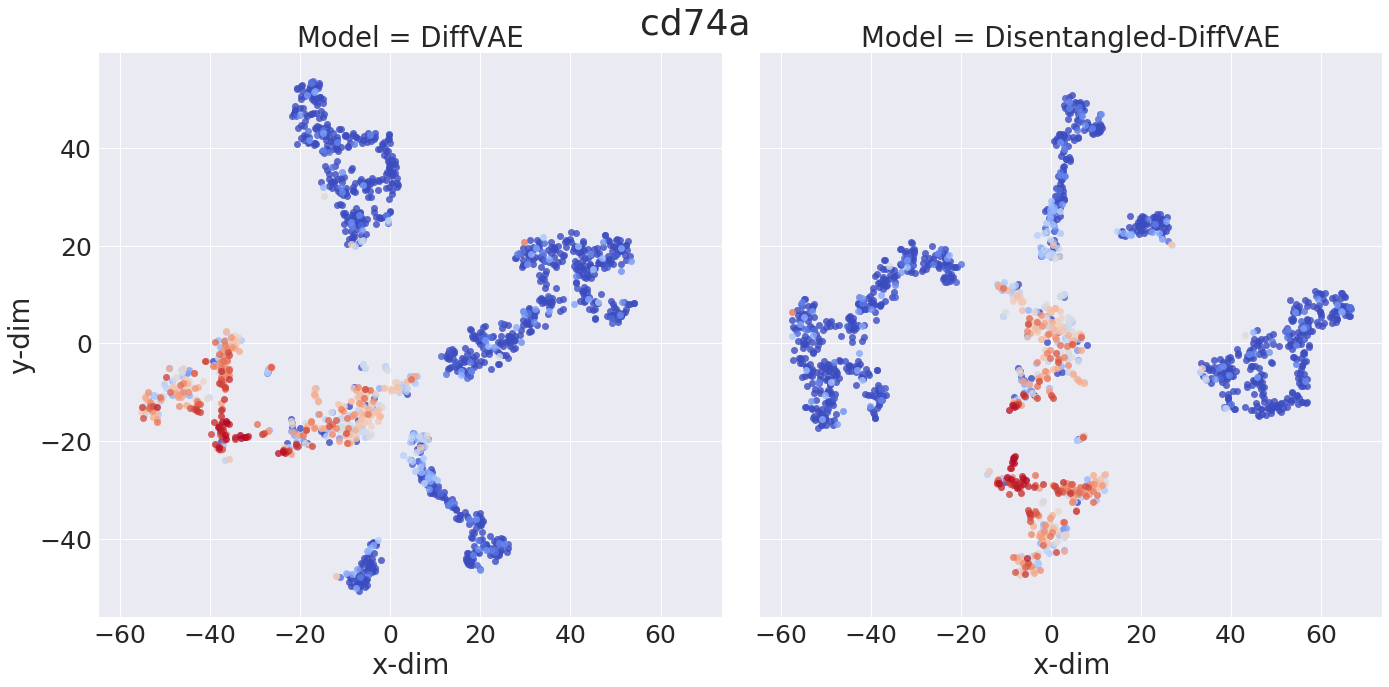

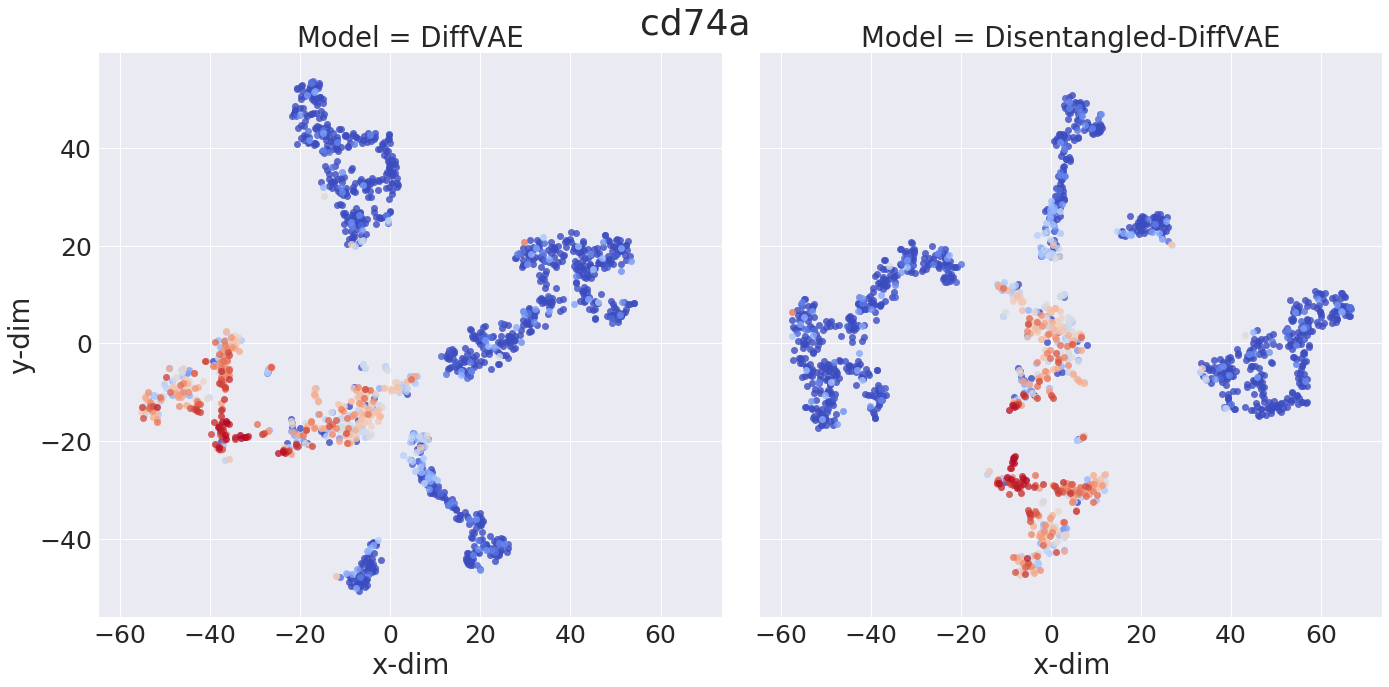

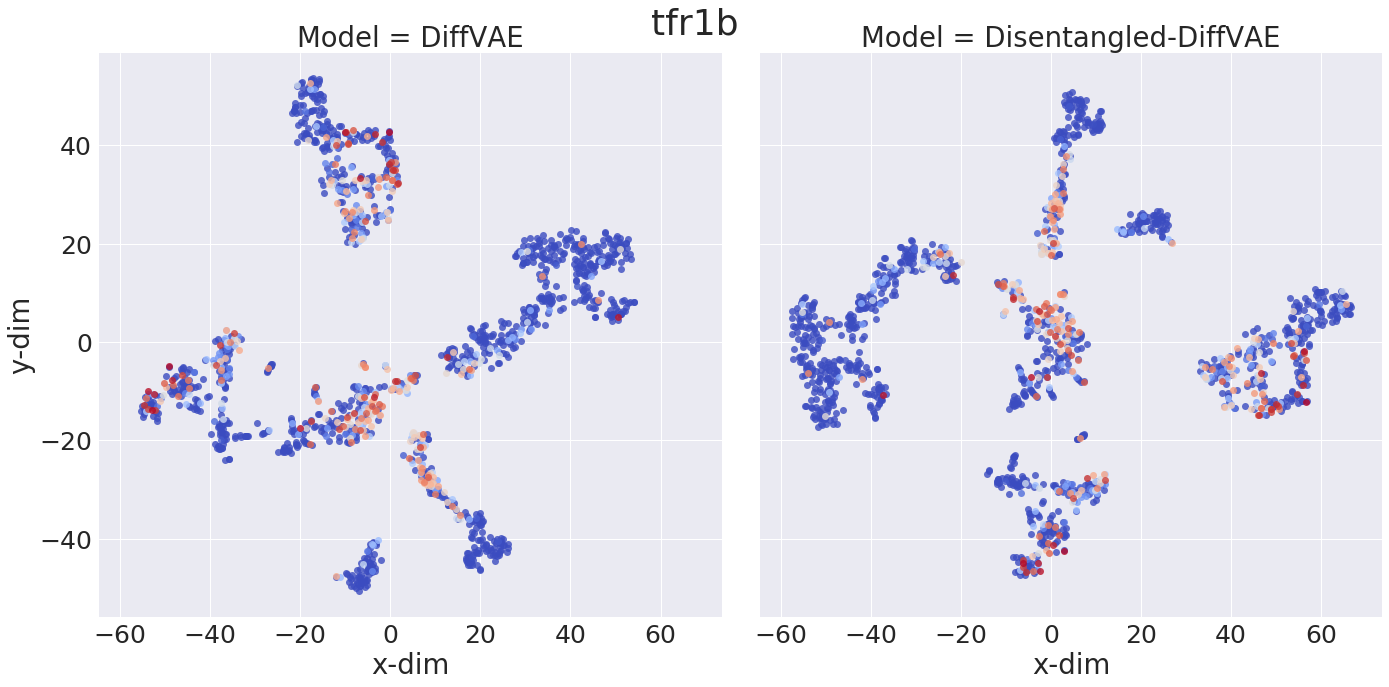

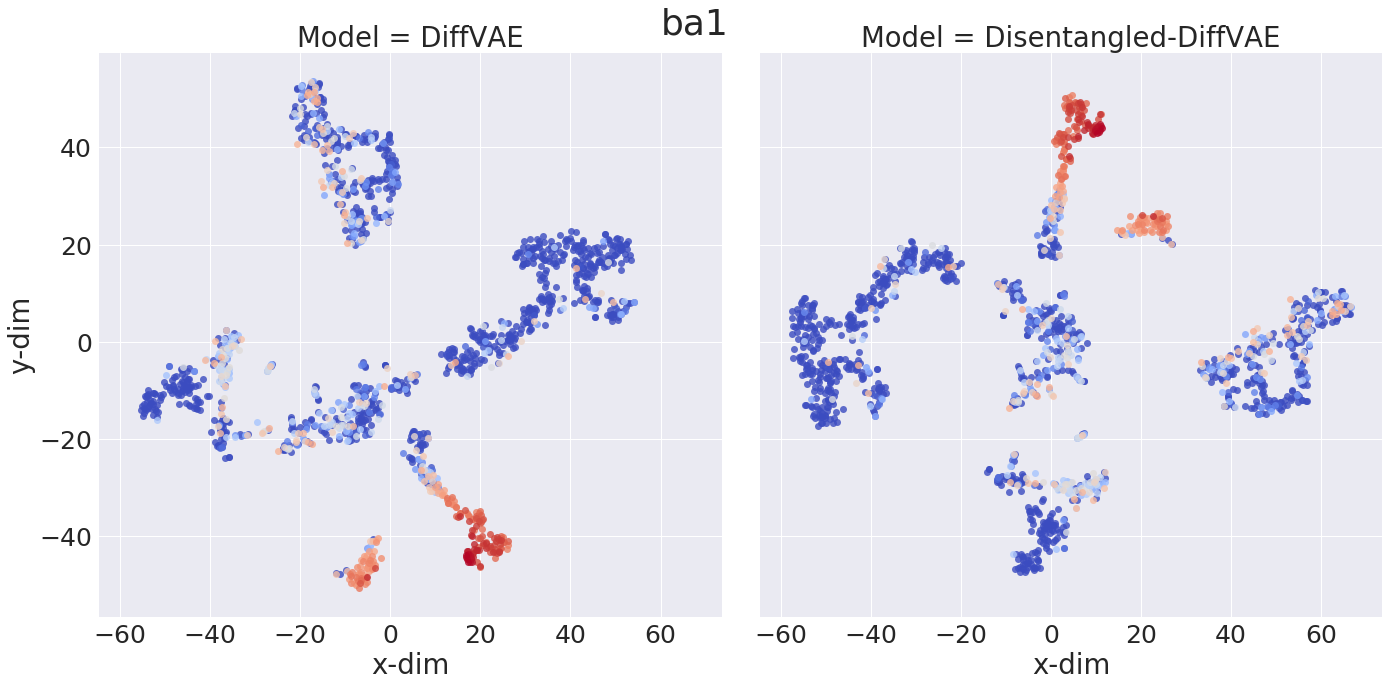

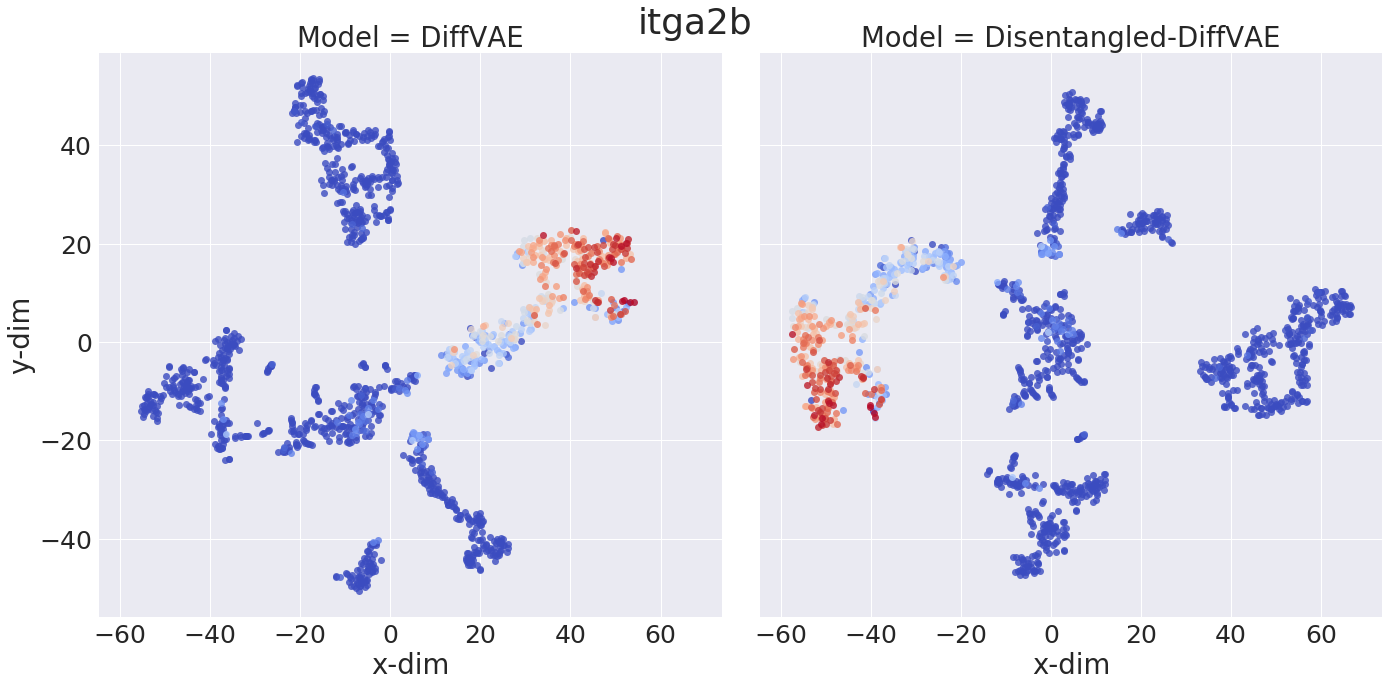

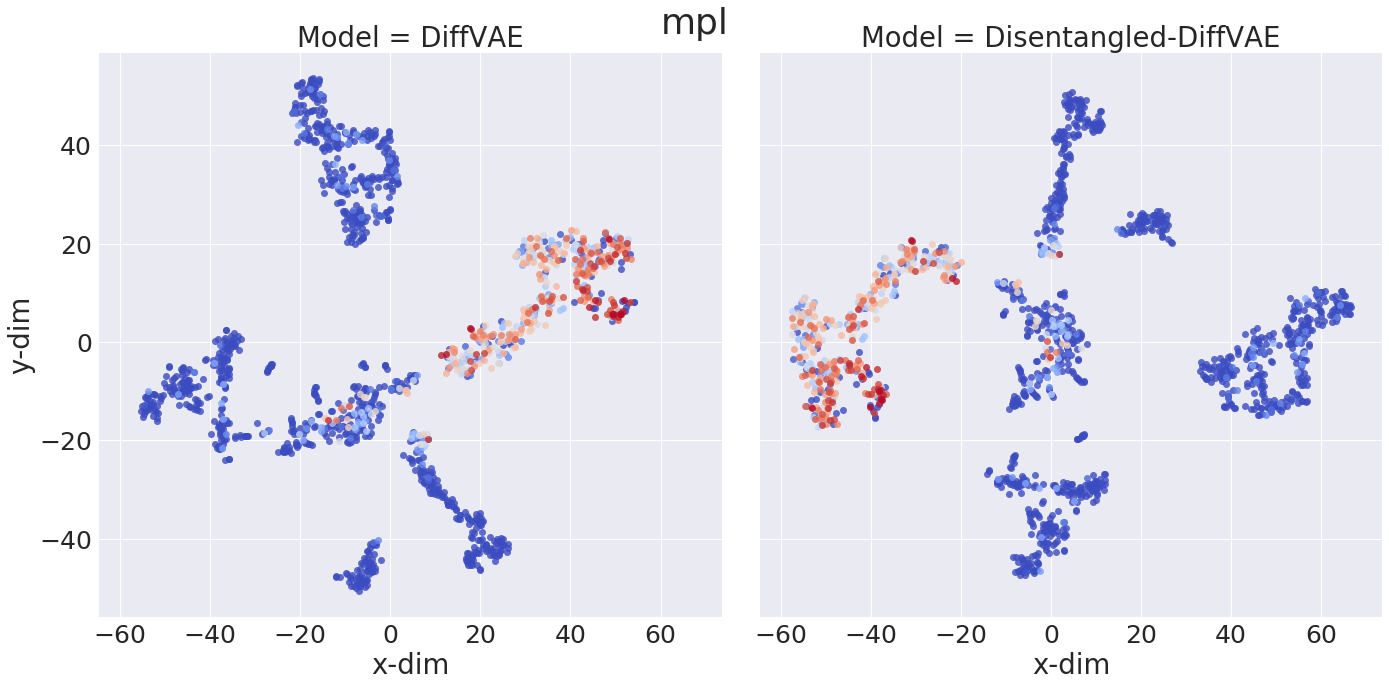

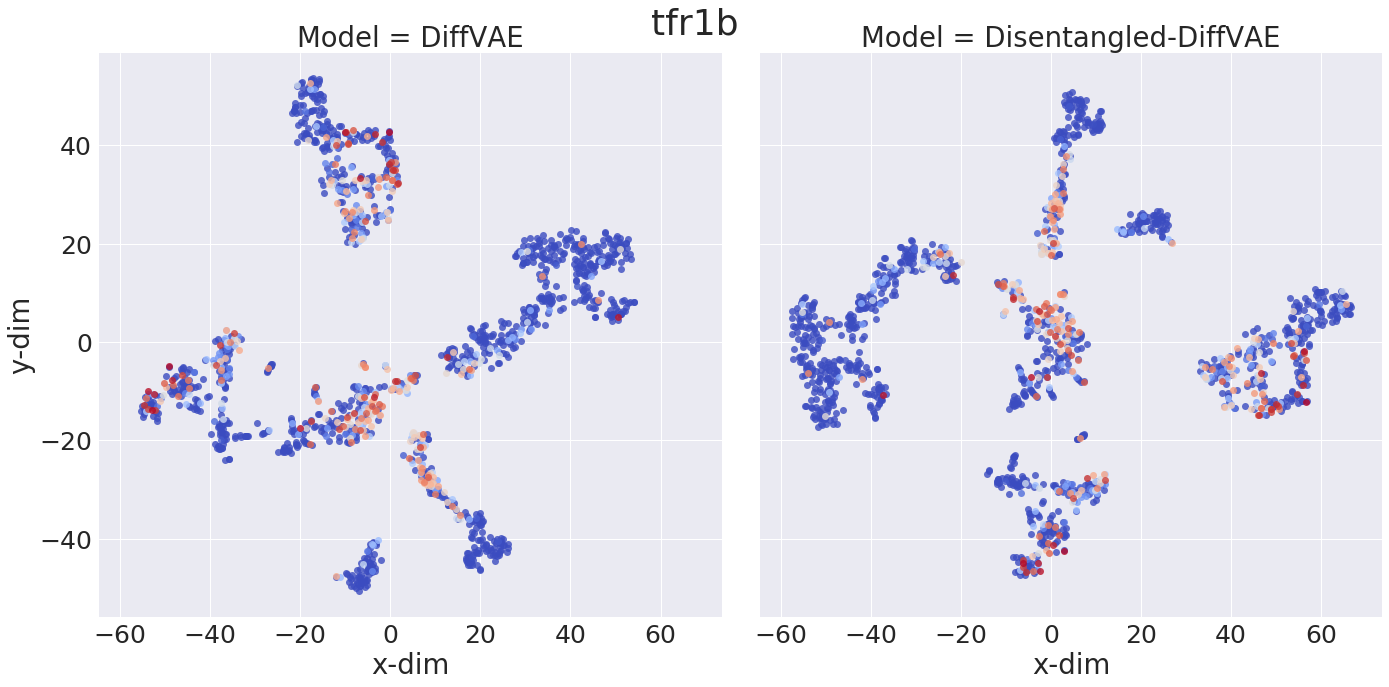

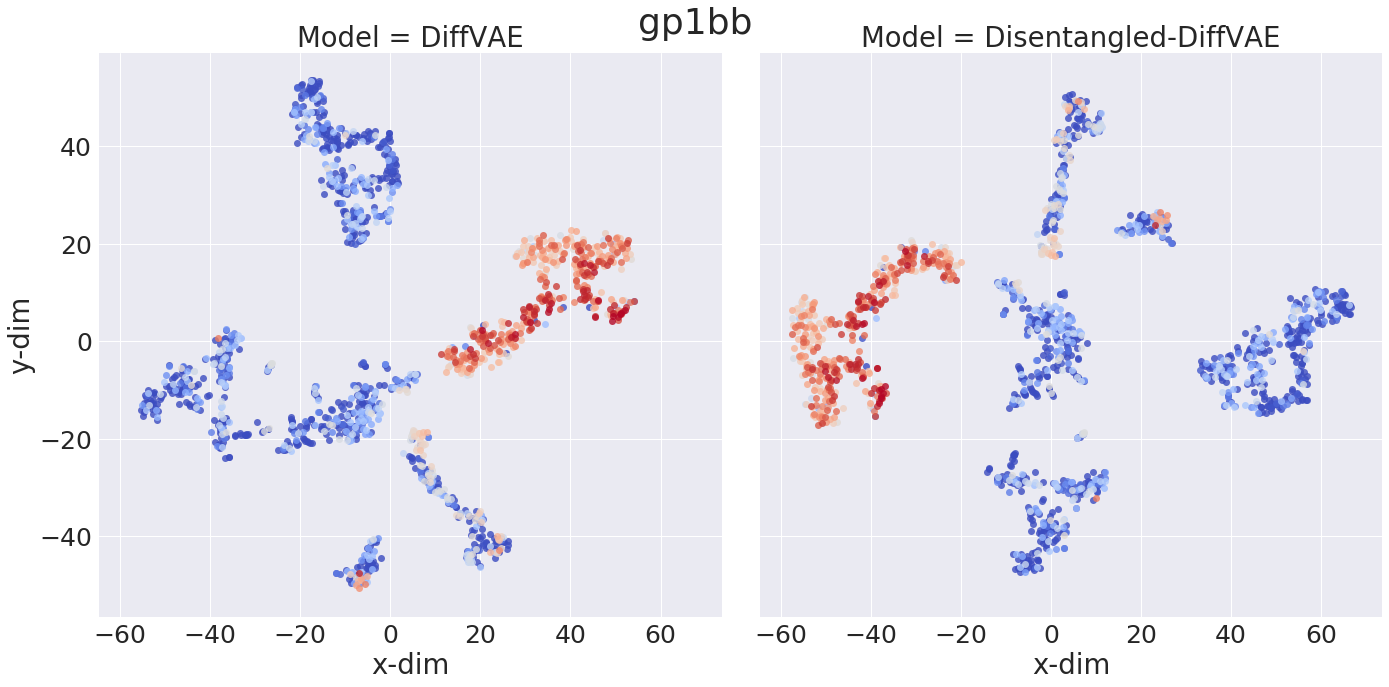

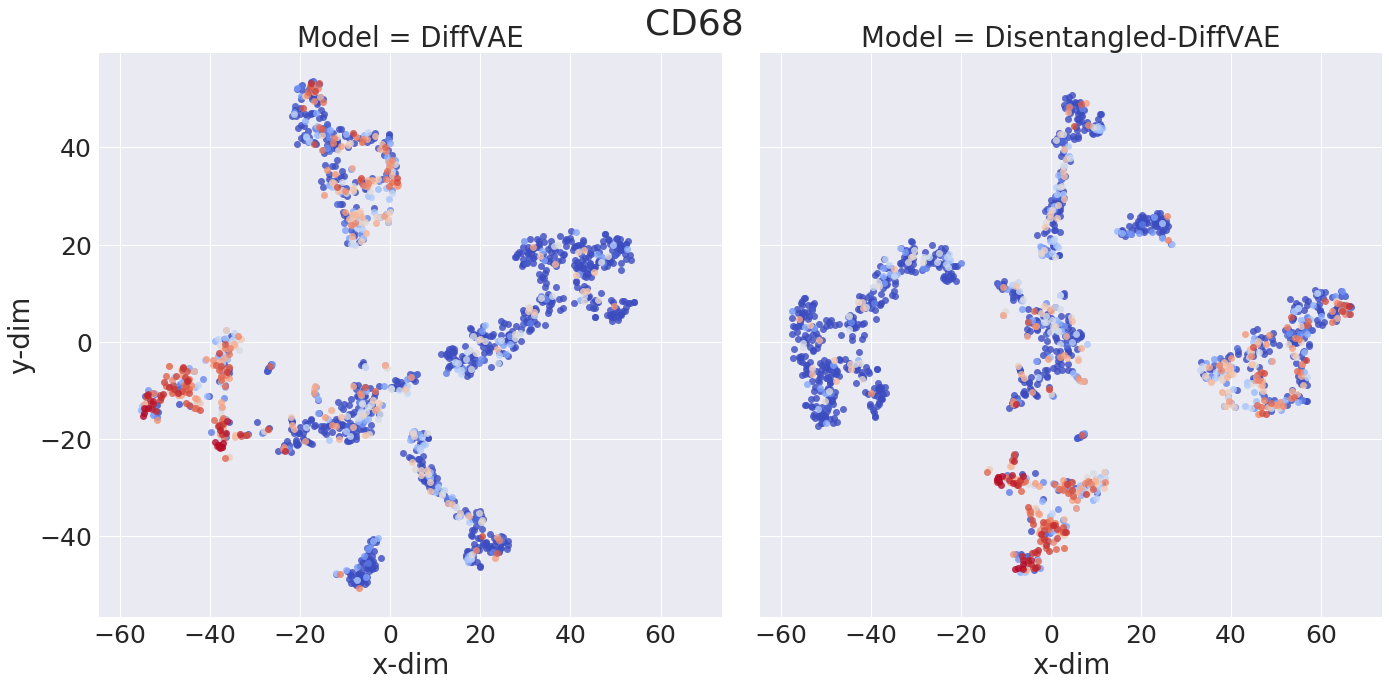

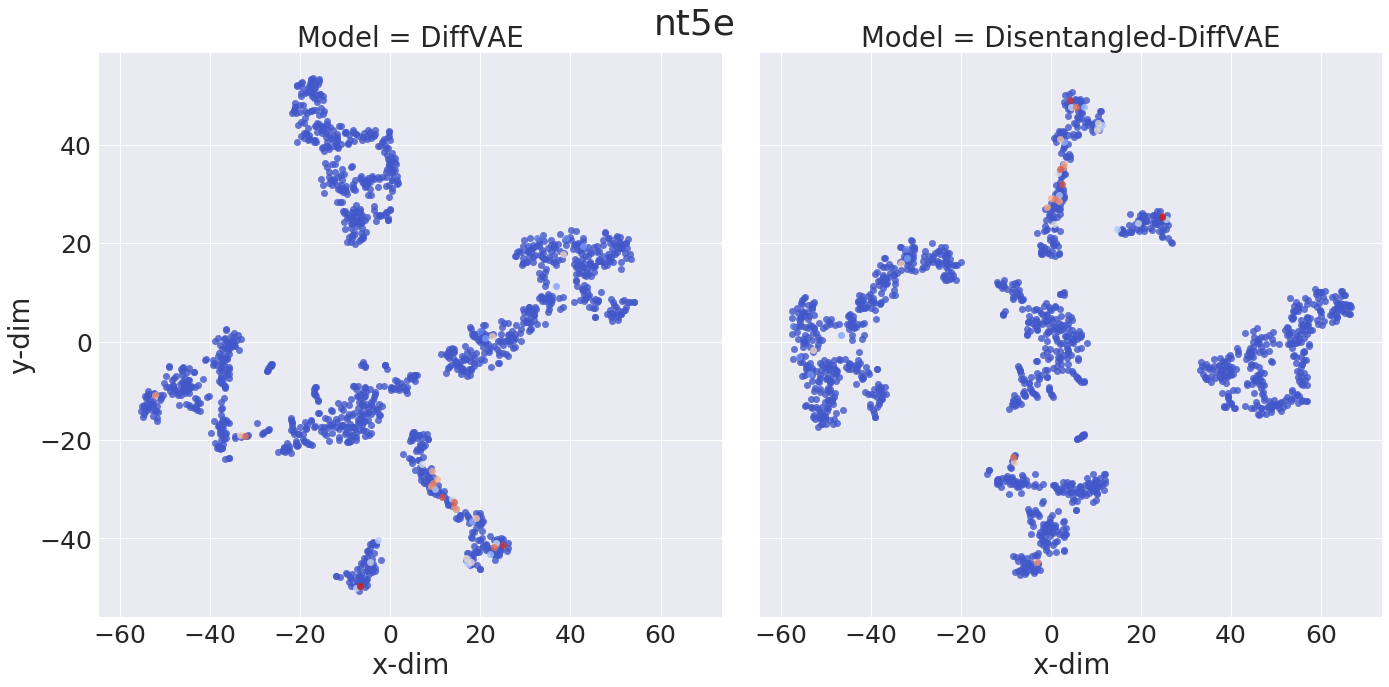

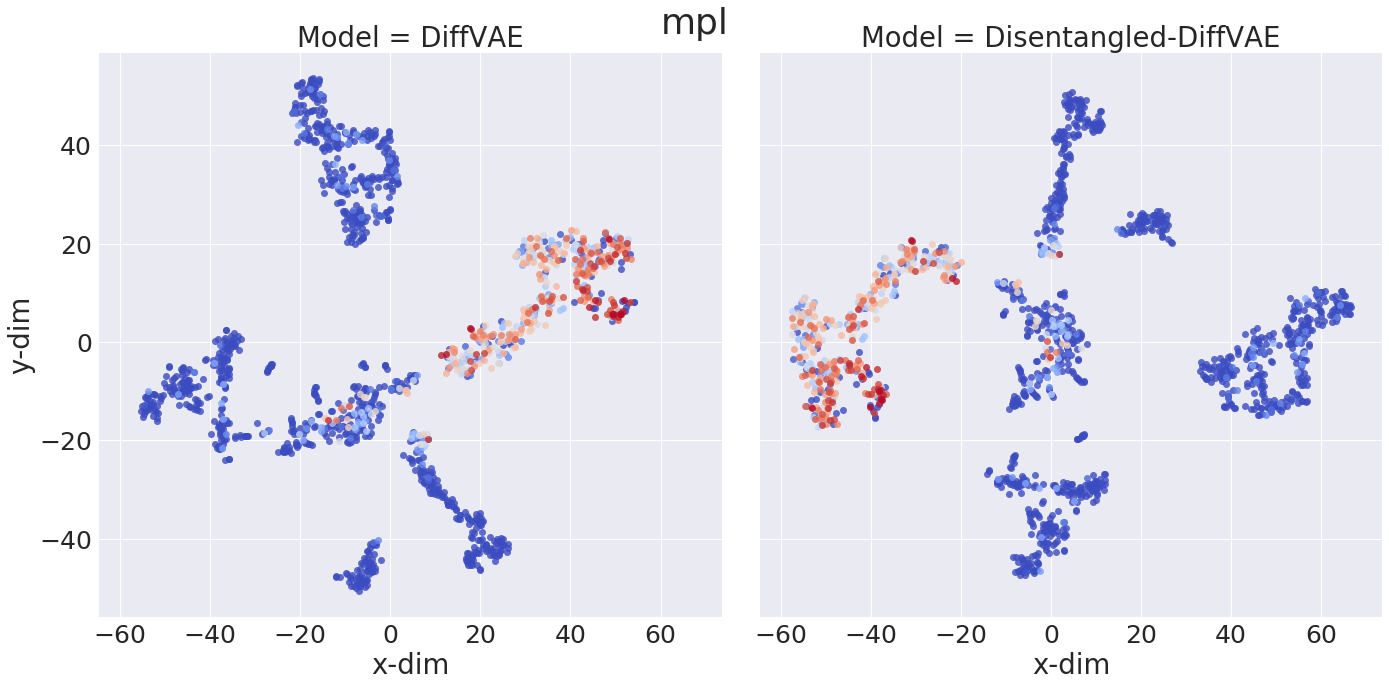

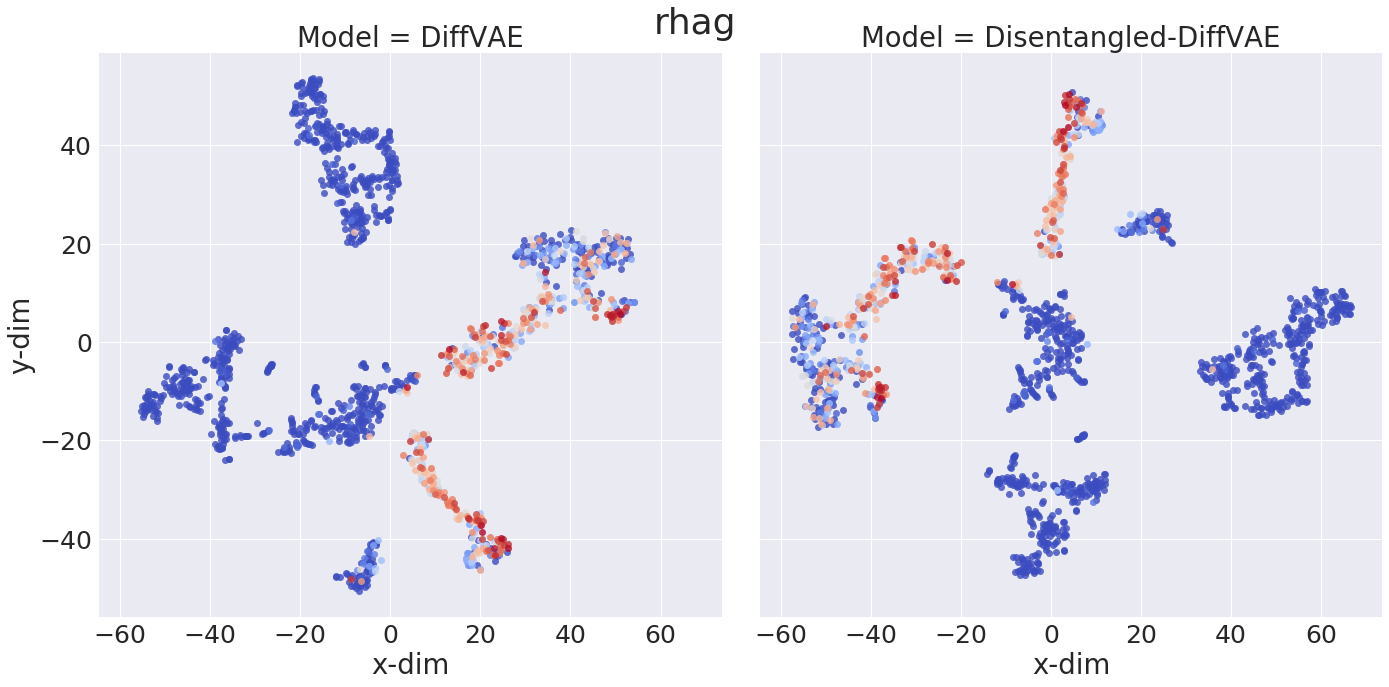

In [32]:
plot_GE_latent_encoding(markers_labels, sample_enc_tsne_dis, sample_enc_tsne, 50, genes_names, markers_indexes)


## Clustering over GE'


In [33]:
sample = dataset_train.x_data.to(device)
sample_enc2 = model.encode(sample.view(-1, 1845))[0].cpu()

# find the decoded representation of the data
sample_dec= model.decode(sample_enc2.cuda().view(-1, 50)).cpu()
sample_dec2=sample_dec.detach().numpy()

#run tSNE over original and decoded representation
sample_tsne_GE=TSNE(n_components=2).fit_transform(sample)
sample_tsne_GE_dec=TSNE(n_components=2).fit_transform(sample_dec2)

print(sample_dec2.shape)

(1422, 1845)


In [34]:
# clustering over the GE'

clusters_gaussian_TSNE_GE=compute_clustering_gaussian(sample_tsne_GE, num_clusters=5, embedding_type='TSNE')
clusters_gaussian_GE=compute_clustering_gaussian(sample2, num_clusters=5, embedding_type='')

clusters_kmeans_TSNE_GE=compute_clustering_kmeans(sample_tsne_GE, num_clusters=5, embedding_type='TSNE')
clusters_kmeans_GE=compute_clustering_kmeans(sample2, num_clusters=5, embedding_type='')

clusters_gaussian_TSNE_GE_dec=compute_clustering_gaussian(sample_tsne_GE_dec, num_clusters=5, embedding_type='TSNE')
clusters_gaussian_GE_dec=compute_clustering_gaussian(sample_dec2, num_clusters=5, embedding_type='')

clusters_kmeans_TSNE_GE_dec=compute_clustering_kmeans(sample_tsne_GE_dec, num_clusters=5, embedding_type='TSNE')
clusters_kmeans_GE_dec=compute_clustering_kmeans(sample_dec2, num_clusters=5, embedding_type='')

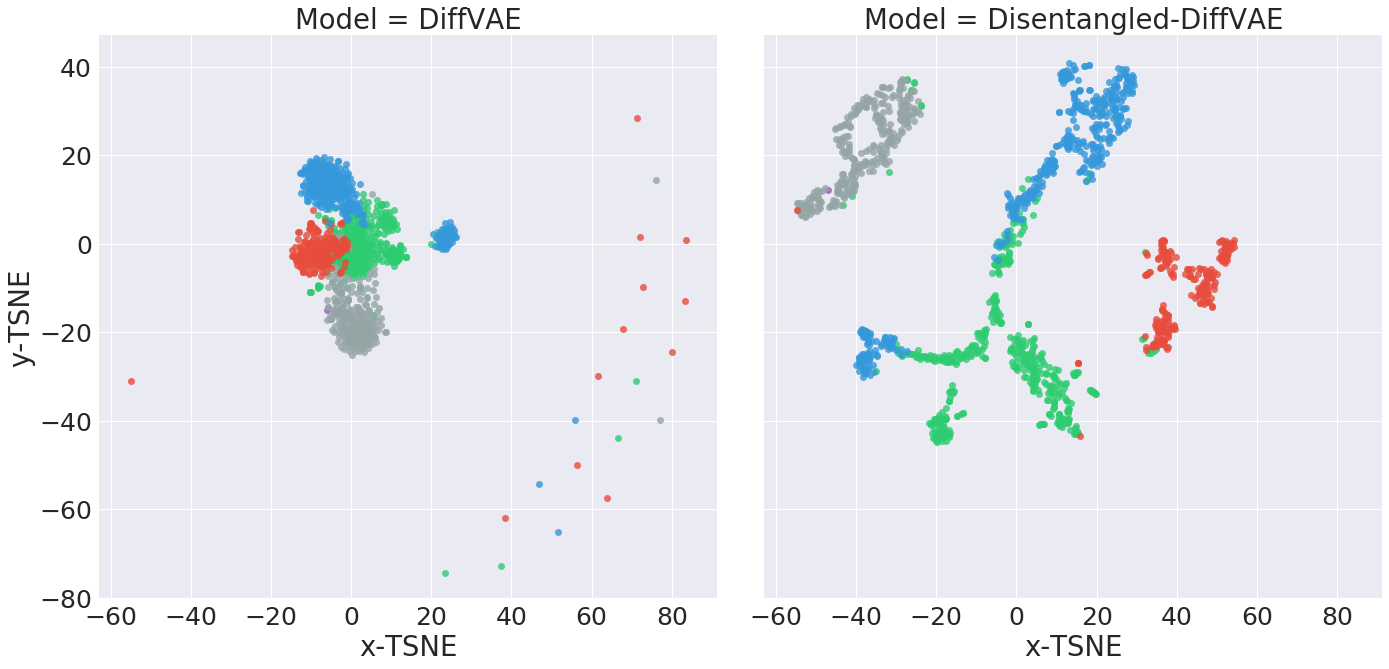

In [35]:
plot_latent_encoding(clusters_gaussian_GE, sample_tsne_GE, sample_tsne_GE_dec, n_components=50)

In [36]:
## map from GE' to clusters and identify relevant genes
labels_clusters_GE = np.array([clusters_gaussian_GE_dec, clusters_kmeans_GE_dec])
print(labels_clusters_GE.astype(str))


[['0' '0' '4' ..., '1' '1' '1']
 ['0' '0' '2' ..., '2' '2' '2']]


In [37]:
from Clustering.clusters_to_reconstructed_GE import compute_diff_capacity_genes

In [38]:
latent_diff=compute_diff_capacity_genes(sample_dec2, labels_clusters_GE[0,:], 'dis', genes_names)

1845
{0: 2, 1: 0, 2: 0, 3: 42, 4: 0, 5: 0}
{0: 4, 1: 0, 2: 0, 3: 31, 4: 0, 5: 0}
{0: 54, 1: 6, 2: 0, 3: 9, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 51, 4: 0, 5: 0}
{0: 4, 1: 0, 2: 54, 3: 0, 4: 0, 5: 0}
{0: 52, 1: 0, 2: 2, 3: 0, 4: 1, 5: 0}
{0: 0, 1: 131, 2: 0, 3: 0, 4: 2, 5: 0}
{0: 62, 1: 0, 2: 0, 3: 2, 4: 1, 5: 0}
{0: 9, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 76, 4: 0, 5: 0}
{0: 12, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 11, 2: 0, 3: 0, 4: 35, 5: 0}
{0: 20, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 68, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 137, 1: 0, 2: 10, 3: 0, 4: 0, 5: 0}
{0: 38, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0}
{0: 9, 1: 0, 2: 0, 3: 0, 4: 28, 5: 0}
{0: 22, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 38, 4: 0, 5: 0}
{0: 49, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 76, 4: 0, 5: 0}
{0: 36, 1: 0, 2: 0, 3: 6, 4: 0, 5: 0}
{0: 5, 1: 0, 2: 0, 3: 10, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 65, 4: 0, 5: 0}
{0: 9, 1: 2, 2: 43, 3: 12, 4: 0, 5: 0}
{0: 19, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0:

{0: 17, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 68, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 73, 4: 0, 5: 0}
{0: 69, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 67, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 79, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 15, 1: 0, 2: 0, 3: 11, 4: 0, 5: 0}
{0: 32, 1: 0, 2: 0, 3: 7, 4: 1, 5: 0}
{0: 38, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 13, 1: 0, 2: 0, 3: 11, 4: 0, 5: 0}
{0: 12, 1: 0, 2: 0, 3: 74, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 43, 4: 0, 5: 0}
{0: 0, 1: 13, 2: 0, 3: 85, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 88, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 25, 4: 1, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 69, 4: 0, 5: 0}
{0: 9, 1: 0, 2: 0, 3: 9, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 79, 4: 0, 5: 0}
{0: 28, 1: 0, 2: 62, 3: 0, 4: 0, 5: 0}
{0: 36, 1: 0, 2: 0, 3: 2, 4: 0, 5: 0}
{0: 18, 1: 0, 2: 0, 3: 11, 4: 0, 5: 0}
{0: 0, 1: 87, 2: 0, 3: 0, 4: 1, 5: 0}
{0: 106, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 121, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 64, 4: 0, 5: 0}
{0: 11

/local/scratch/ha376/basic_VAE_pytorch/Clustering/clusters_to_reconstructed_GE.py:29: RuntimeWarning: invalid value encountered in true_divide
  counter = np.array(list(counter_dict.values())) / float(len(variable_cells))


{0: 12, 1: 0, 2: 35, 3: 0, 4: 12, 5: 0}
{0: 14, 1: 0, 2: 0, 3: 19, 4: 3, 5: 0}
{0: 3, 1: 0, 2: 68, 3: 0, 4: 0, 5: 0}
{0: 109, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 6, 1: 0, 2: 1, 3: 37, 4: 0, 5: 0}
{0: 67, 1: 0, 2: 0, 3: 3, 4: 9, 5: 0}
{0: 9, 1: 0, 2: 32, 3: 0, 4: 0, 5: 0}
{0: 15, 1: 0, 2: 0, 3: 18, 4: 0, 5: 0}
{0: 0, 1: 12, 2: 0, 3: 0, 4: 57, 5: 0}
{0: 0, 1: 5, 2: 0, 3: 0, 4: 96, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 77, 4: 0, 5: 0}
{0: 12, 1: 0, 2: 0, 3: 19, 4: 0, 5: 0}
{0: 0, 1: 65, 2: 0, 3: 0, 4: 2, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 61, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 83, 4: 0, 5: 0}
{0: 6, 1: 0, 2: 23, 3: 2, 4: 0, 5: 0}
{0: 103, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 2, 1: 0, 2: 0, 3: 14, 4: 0, 5: 0}
{0: 4, 1: 0, 2: 72, 3: 30, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 33, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 132, 3: 0, 4: 0, 5: 0}
{0: 7, 1: 0, 2: 2, 3: 8, 4: 0, 5: 0}
{0: 21, 1: 0, 2: 0, 3: 7, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 73, 4: 0, 5: 0}
{0: 60, 1: 0, 2: 0, 3: 18, 4: 0, 5: 0}
{0: 49, 1: 0, 2: 7, 3: 7, 4: 6, 5: 0}
{0

{0: 41, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 28, 1: 0, 2: 8, 3: 0, 4: 0, 5: 0}
{0: 17, 1: 4, 2: 20, 3: 3, 4: 1, 5: 0}
{0: 13, 1: 0, 2: 0, 3: 10, 4: 0, 5: 0}
{0: 89, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0}
{0: 43, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 50, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 89, 3: 0, 4: 0, 5: 0}
{0: 36, 1: 0, 2: 0, 3: 1, 4: 0, 5: 0}
{0: 15, 1: 0, 2: 0, 3: 7, 4: 6, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 25, 5: 0}
{0: 12, 1: 0, 2: 0, 3: 36, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 30, 4: 0, 5: 0}
{0: 28, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 15, 1: 0, 2: 3, 3: 16, 4: 0, 5: 0}
{0: 0, 1: 43, 2: 0, 3: 4, 4: 0, 5: 0}
{0: 3, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0}
{0: 17, 1: 0, 2: 0, 3: 9, 4: 0, 5: 0}
{0: 5, 1: 0, 2: 0, 3: 2, 4: 0, 5: 0}
{0: 5, 1: 0, 2: 0, 3: 7, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 163, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0}
{0: 0, 1: 0, 2: 0, 3: 67, 4: 0, 5: 0}
{0: 53, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
{0: 1, 1: 0, 2: 0, 3: 87, 4: 0, 5: 0}
{0: 0, 1: 45, 2: 0, 3: 0, 4: 25, 5: 0}
{0: 0, 1: 

In [39]:
Map_components_clusters=np.array([latent_diff['Genes'][np.where(latent_diff['Percentage']>90.)[0]],
                                 latent_diff['Cell type'][np.where(latent_diff['Percentage']>90.)[0]],
                                 latent_diff['Names'][np.where(latent_diff['Percentage']>90.)[0]]])
Map_comp_clust = pd.DataFrame(Map_components_clusters.T, columns=['Genes', 'Cell type', 'Names'])
print(latent_diff['Cell type'][np.where(latent_diff['Cell type']=='2')[0]].shape)
#print(Map_comp_clust['Names'][np.where(Map_comp_clust['Cell type']=='2')[0]])

(1845,)


In [40]:
## which genes are characteristic of just one cluster?
clust1=Map_comp_clust['Genes'][np.where(Map_comp_clust['Cell type']=='1')[0]]
clust2=Map_comp_clust['Genes'][np.where(Map_comp_clust['Cell type']=='2')[0]]
clust3=Map_comp_clust['Genes'][np.where(Map_comp_clust['Cell type']=='3')[0]]
print (np.setxor1d(clust1,clust2).shape)
print (clust2.shape)
print (np.array(list(set(clust1) & set(clust2))).shape)

(218,)
(148,)
(0,)
